In [136]:
# --- General Data Analysis Imports ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# --- String, Parsing, and Utilities ---
import re
from collections import Counter
from urllib.parse import unquote, urlparse, parse_qs

# --- Scikit-Learn (Preprocessing, Modeling, Dimensionality Reduction) ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances

# --- Math ---
import math

# missing data visualization ---
import missingno as msno

from google.colab import drive
drive.mount('/content/drive')

# --- Load flattened dataset (adapt path as needed) ---
df_flat = pd.read_csv('/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_flat.csv')
print("Shape:", df_flat.shape)
df_flat.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (169955, 54)


method                                                url  \
0    GET  http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...   
1    GET                 http://127.0.0.1:5000/greet/Capito   
2    GET                    http://127.0.0.1:5000/bookstore   
3    GET  http://127.0.0.1:5000/orders/check/exists?val=...   
4   POST  http://127.0.0.1:5000/categories/check/all?id=...   

               req_body   Attack_Tag        req_Host  \
0                   NaN          XSS  127.0.0.1:5000   
1                   NaN          NaN  127.0.0.1:5000   
2                   NaN          NaN  127.0.0.1:5000   
3                   NaN  Log Forging  127.0.0.1:5000   
4  MkdXwyHaWCdnLhoXJDzY          NaN  127.0.0.1:5000   

                                      req_User-Agent  \
0  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   
1  Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...   
2                             python-requests/2.28.1   
3  Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...   
4  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...   

                req_Accept-Encoding req_Accept req_Connection  \
0                 gzip, deflate, br        */*     keep-alive   
1                 gzip, deflate, br        */*     keep-alive   
2                     gzip, deflate        */*     keep-alive   
3                 gzip, deflate, br        */*     keep-alive   
4  x-gzip, x-deflate, gzip, deflate        */*     keep-alive   

  req_Sec-Ch-Ua-Mobile  ... severity_sqli_libinjection  \
0                   ?0  ...                          0   
1                   ?0  ...                          0   
2                  NaN  ...                          0   
3                   ?0  ...                          0   
4                   ?1  ...                          0   

  severity_sqli_union_select severity_xss_angularjs_template  \
0                          0                               0   
1                          0                               0   
2                          0                               0   
3                          0                               0   
4                          0                               0   

  severity_xss_html_injection severity_xss_javascript_method  \
0                           1                              1   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

  severity_xss_libinjection severity_xss_libinjection_alt  \
0                         1                             0   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   

  severity_xss_script_tag severity_xss_tag_handler  alert_count  
0                       1                        1            6  
1                       0                        0            0  
2                       0                        0            0  
3                       0                        0            2  
4                       0                        0            3  

[5 rows x 54 columns]

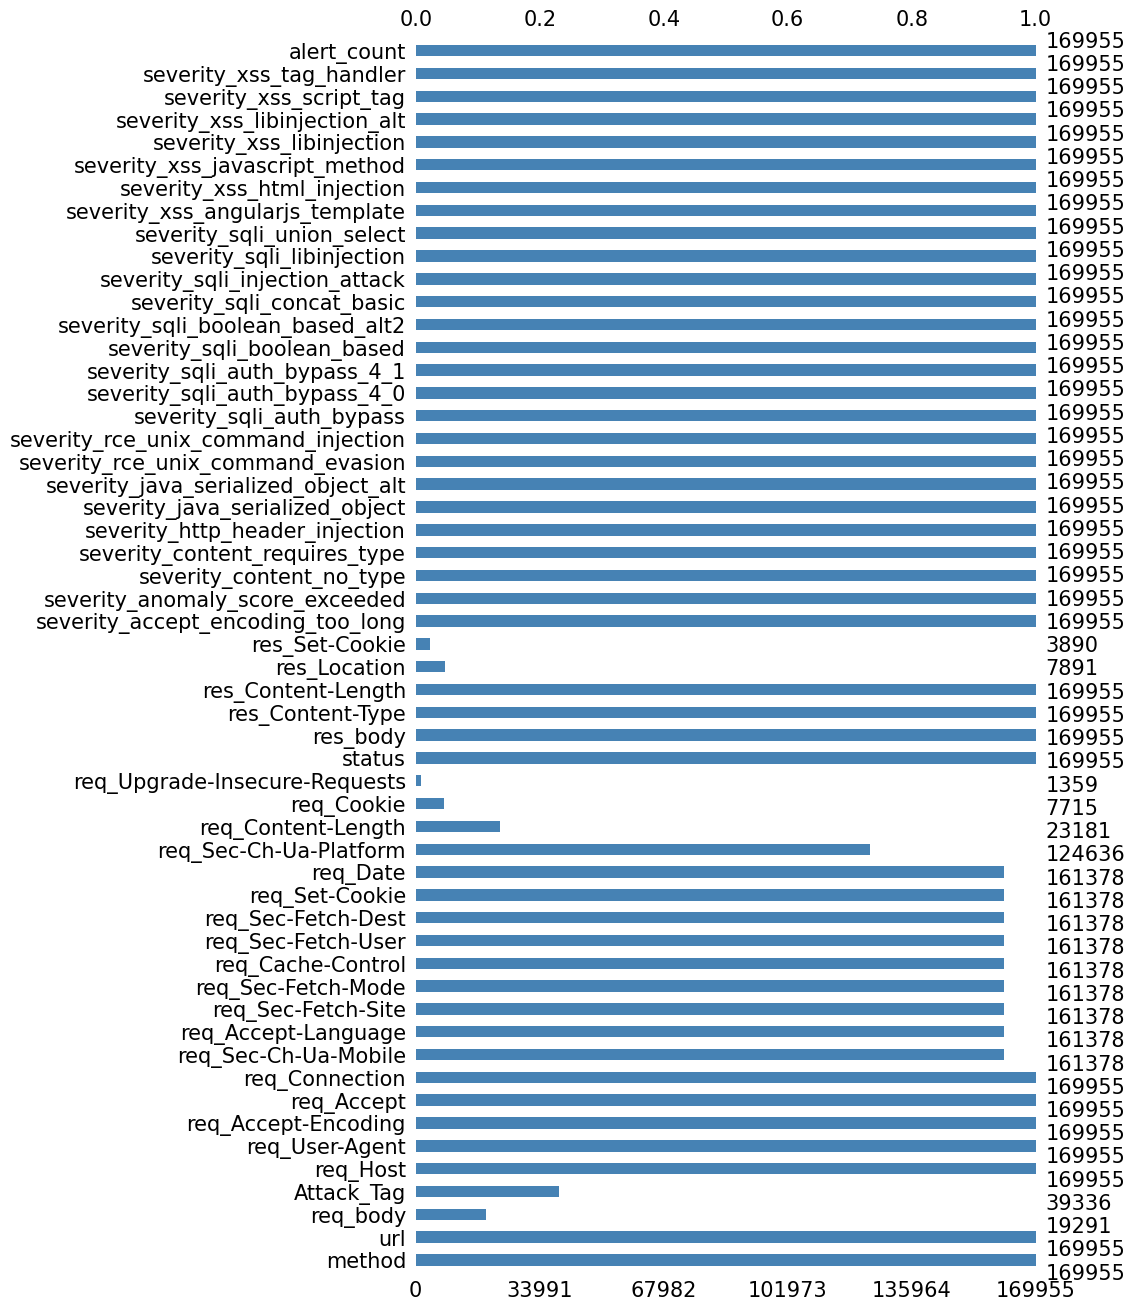

In [137]:
# --- Missing Value Analysis using missingno ---

# Display a horizontal bar chart showing the count of non-missing values for each feature.
# This visualization quickly highlights columns with a high percentage of missing data.
msno.bar(
    df_flat,
    figsize=(8, 16),
    fontsize=15,
    color='steelblue'
)
plt.show()

In [138]:
# --- Prepare DataFrame for EDA and Add a Binary Label ---

# Create a working copy of the main DataFrame for EDA purposes
data_viz = pd.DataFrame(df_flat)

# Add a binary label: 1 if 'Attack_Tag' is not null (i.e., an attack is present), otherwise 0
data_viz['label'] = data_viz['Attack_Tag'].notna().astype(int)

# Display the first few rows to verify correct labeling
print(data_viz[['Attack_Tag', 'label']].head())

    Attack_Tag  label
0          XSS      1
1          NaN      0
2          NaN      0
3  Log Forging      1
4          NaN      0


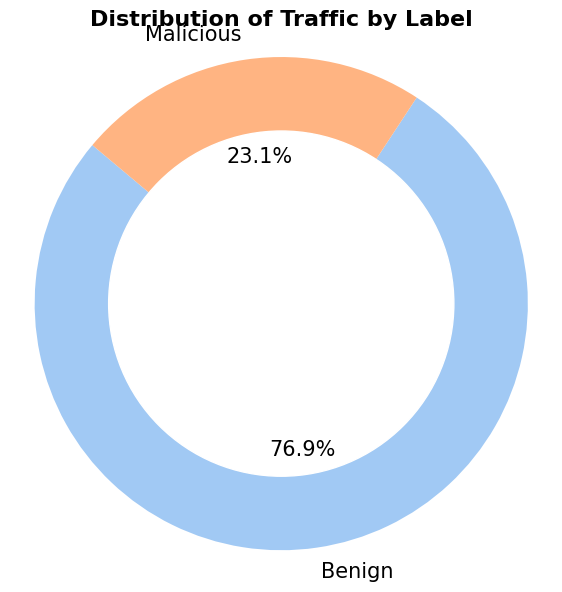

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numeric labels to string labels
label_map = {0: "Benign", 1: "Malicious"}
label_named = data_viz['label'].map(label_map)

# Count occurrences of each mapped label
label_counts = label_named.value_counts()

# Colors for the donut
donut_colors = sns.color_palette("pastel", n_colors=len(label_counts))

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    label_counts,
    labels=label_counts.index,
    colors=donut_colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.4)
)
plt.title('Distribution of Traffic by Label', fontsize=16, weight='bold')
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white', fc='white'))
plt.axis('equal')
plt.show()


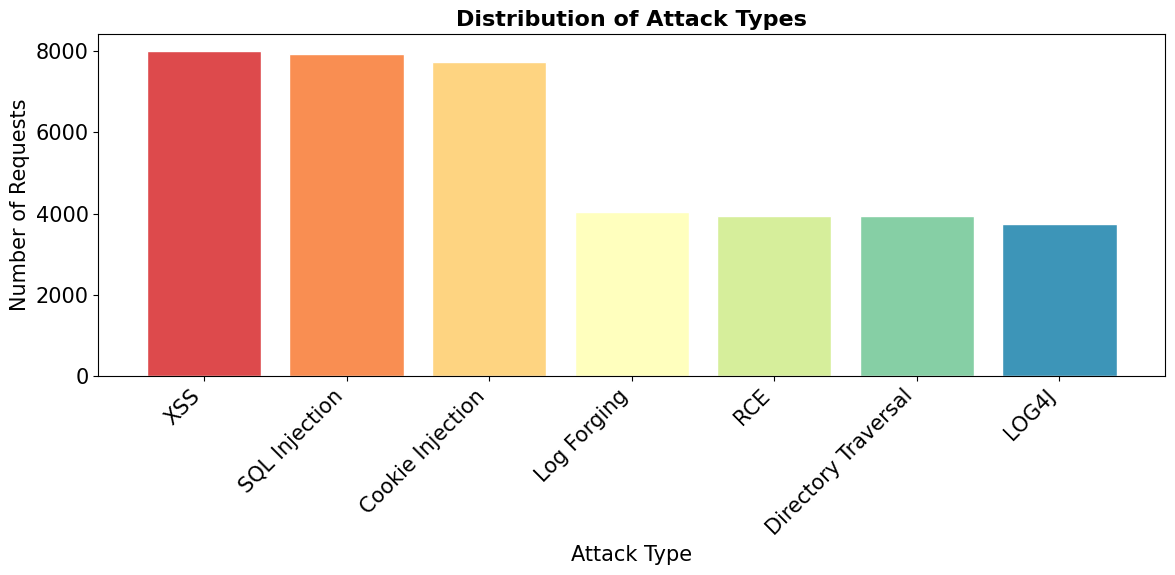

In [140]:
# --- Distribution of Attack Types (Bar Plot) ---

# Filter the dataset to include only attack samples (where 'Attack_Tag' is present)
attack_only = data_viz[data_viz['Attack_Tag'].notna()]

# Count the number of occurrences for each attack type
attack_type_counts = (
    attack_only['Attack_Tag']
    .value_counts()
    .rename_axis('Attack_Type')
    .reset_index(name='Count')
)

# Create a bar plot to visualize the distribution of attack types
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Spectral", n_colors=len(attack_type_counts))

plt.bar(
    attack_type_counts['Attack_Type'],
    attack_type_counts['Count'],
    color=colors,
    edgecolor='white'
)
plt.title("Distribution of Attack Types", fontsize=16, weight='bold')
plt.xlabel("Attack Type")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

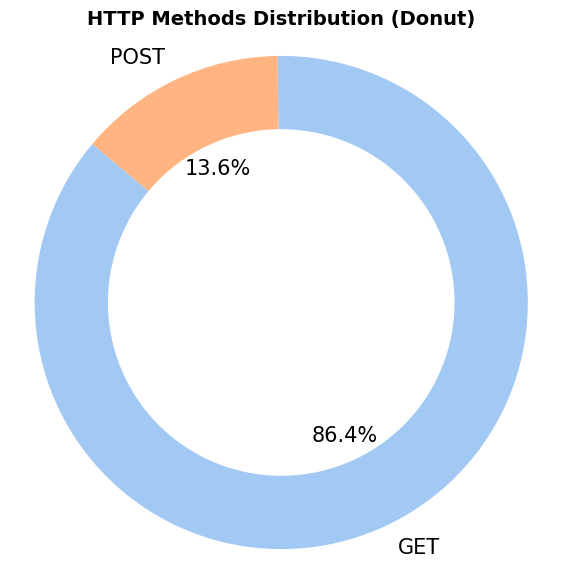

In [141]:
# -- 1. Donut chart of HTTP methods --
method_counts = data_viz['method'].value_counts()
donut_colors = sns.color_palette("pastel")

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    method_counts,
    labels=method_counts.index,
    colors=donut_colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.4)
)
plt.title('HTTP Methods Distribution (Donut)', fontsize=14, weight='bold')
plt.gca().add_artist(plt.Circle((0, 0), 0.7, color='white', fc='white'))
plt.axis('equal')
plt.show()

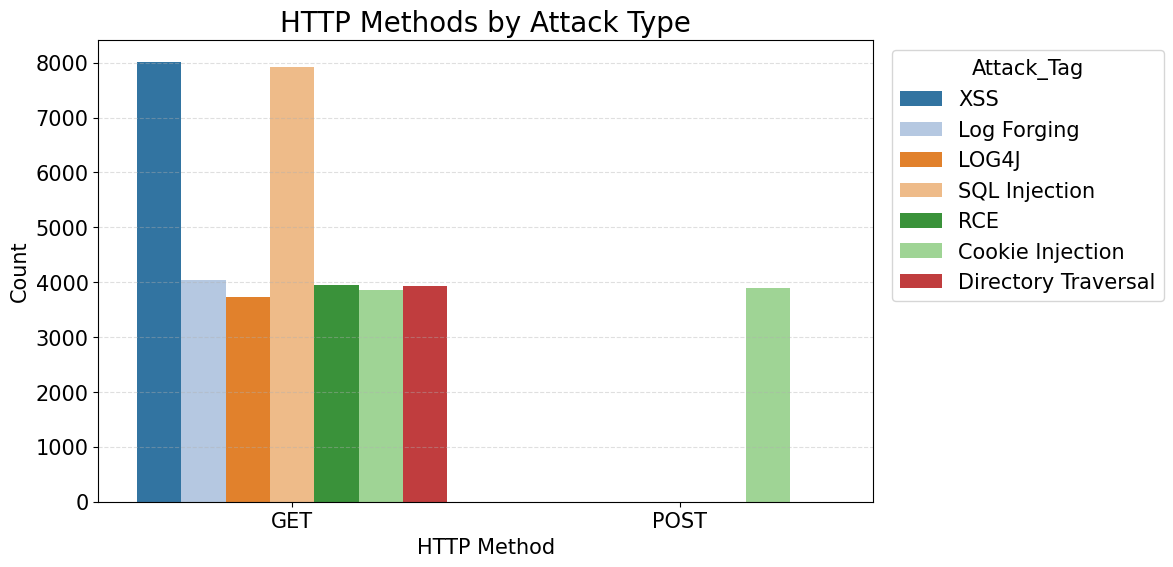

In [142]:
# -- 3. Bar plot: HTTP methods by attack type --
plt.figure(figsize=(10, 6))
sns.countplot(
    data=data_viz,
    x='method',
    hue='Attack_Tag',
    order=method_counts.index,
    palette='tab20'
)
plt.title('HTTP Methods by Attack Type')
plt.xlabel('HTTP Method')
plt.ylabel('Count')
plt.legend(title='Attack_Tag', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

<ipython-input-143-1f5522d933e2>:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-143-1f5522d933e2>:62: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-143-1f5522d933e2>:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-143-1f5522d933e2>:78: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-143-1f5522d933e2>:97: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-143-1f5522d933e2>:115: UserWarning:

set_ticklabels() should only be used with a fixed number o

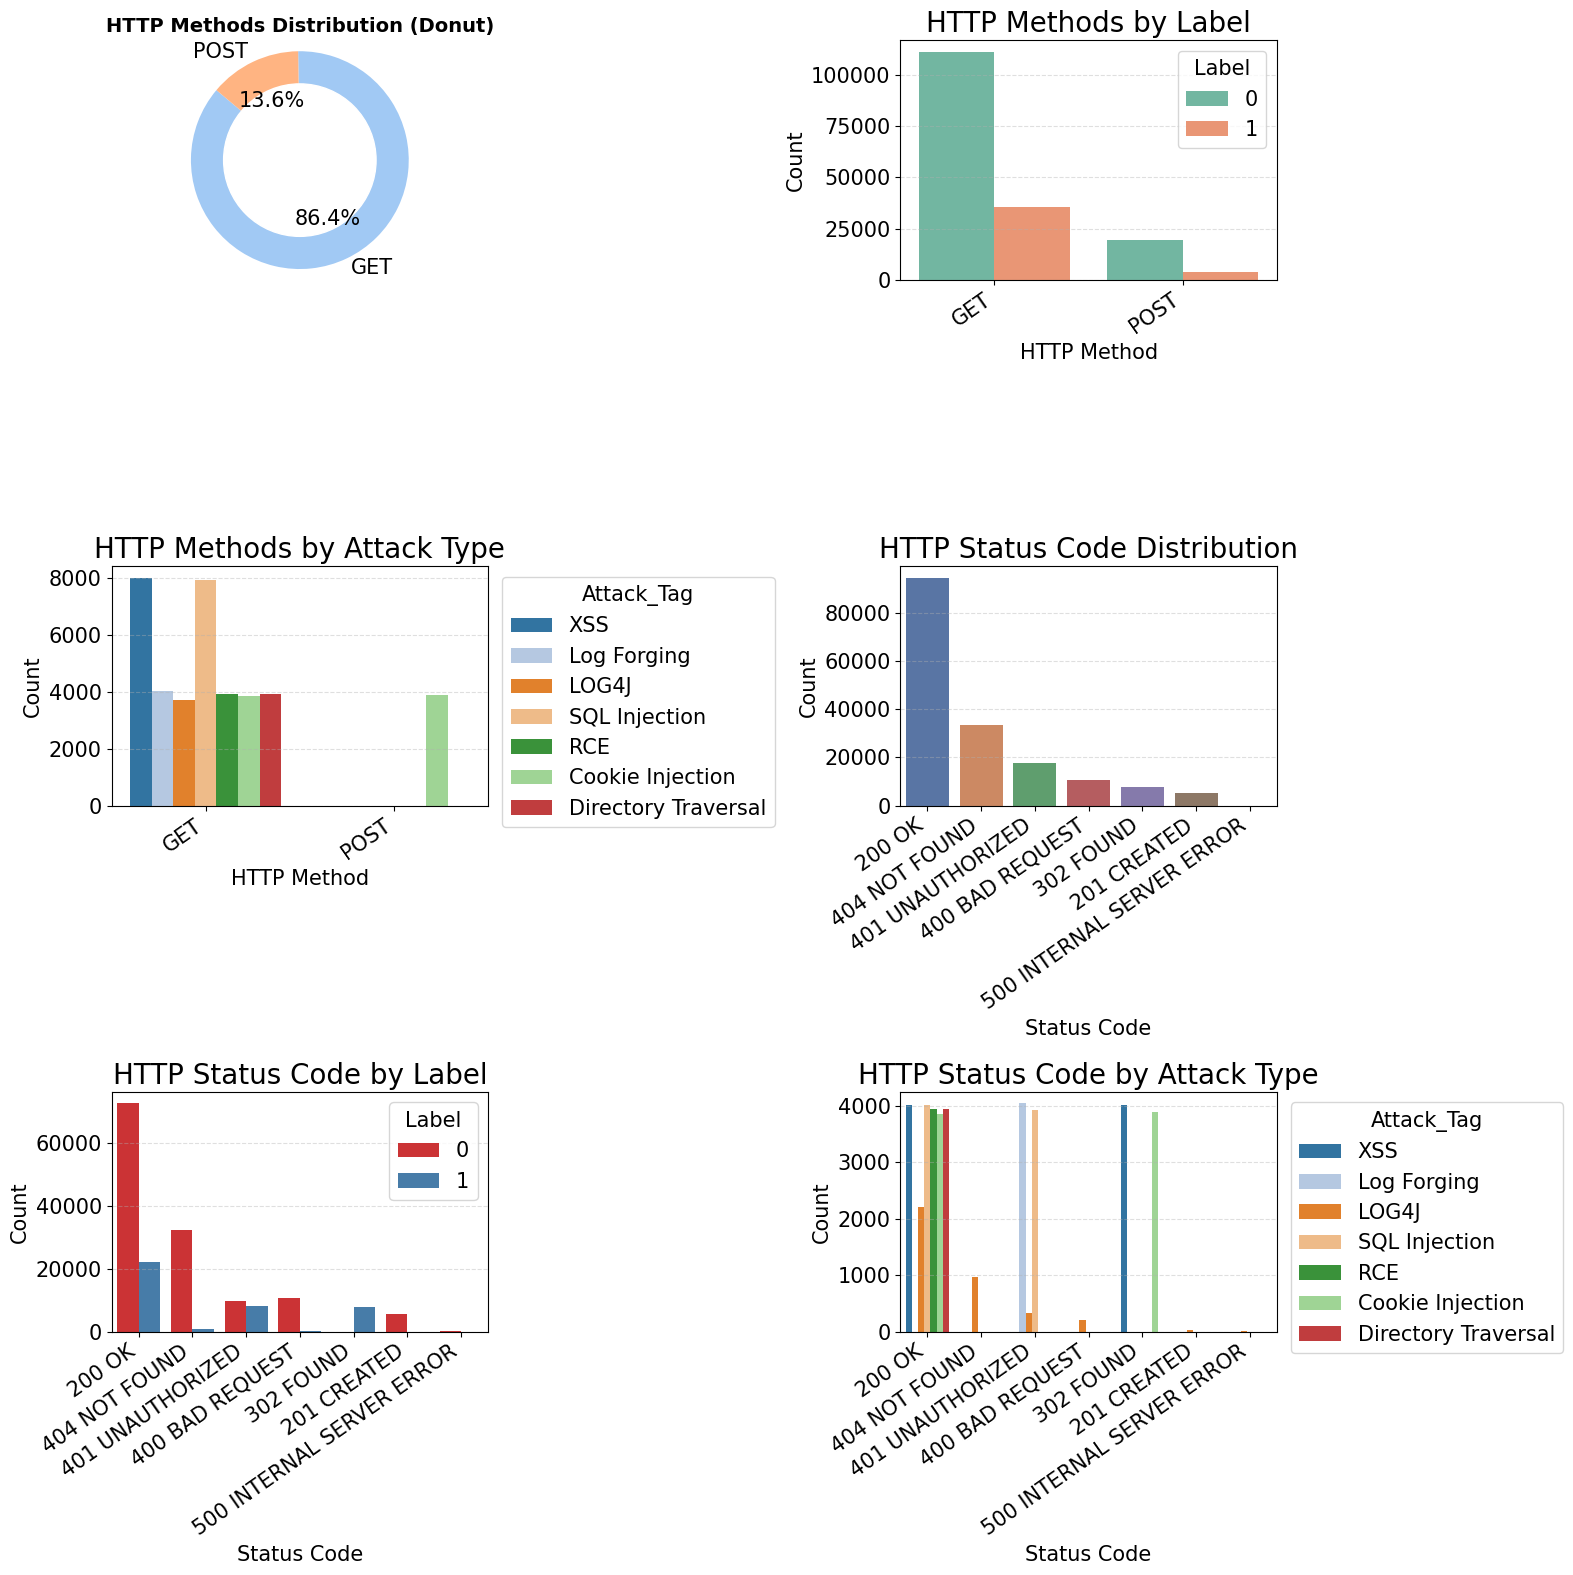

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palettes for the plots
donut_colors = sns.color_palette("pastel")

# Compute counts for HTTP methods and status codes
method_counts = data_viz['method'].value_counts()
status_counts = data_viz['status'].value_counts()

# Create a figure with 6 subplots in 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.35, wspace=0.28)

# -- Row 0 --
# 1. Donut chart of HTTP methods
wedges, texts, autotexts = axes[0, 0].pie(
    method_counts,
    labels=method_counts.index,
    colors=donut_colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.4)
)
axes[0, 0].set_title('HTTP Methods Distribution (Donut)', fontsize=14, weight='bold')
axes[0, 0].add_artist(plt.Circle((0, 0), 0.7, color='white', fc='white'))
axes[0, 0].axis('equal')

# 2. Bar plot: HTTP methods by label
sns.countplot(
    data=data_viz,
    x='method',
    hue='label',
    order=method_counts.index,
    palette='Set2',
    ax=axes[0, 1]
)
axes[0, 1].set_title('HTTP Methods by Label')
axes[0, 1].set_xlabel('HTTP Method')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Label')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.4)
axes[0, 1].set_xticklabels(
    axes[0, 1].get_xticklabels(), rotation=35, ha='right'
)

# -- Row 1 --
# 3. Bar plot: HTTP methods by attack type
sns.countplot(
    data=data_viz,
    x='method',
    hue='Attack_Tag',
    order=method_counts.index,
    palette='tab20',
    ax=axes[1, 0]
)
axes[1, 0].set_title('HTTP Methods by Attack Type')
axes[1, 0].set_xlabel('HTTP Method')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Attack_Tag', bbox_to_anchor=(1.01, 1), loc='upper left')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.4)
axes[1, 0].set_xticklabels(
    axes[1, 0].get_xticklabels(), rotation=35, ha='right'
)

# 4. Bar plot: HTTP status code distribution (all samples)
sns.countplot(
    data=data_viz,
    x='status',
    order=status_counts.index,
    palette='deep',
    ax=axes[1, 1]
)
axes[1, 1].set_title('HTTP Status Code Distribution')
axes[1, 1].set_xlabel('Status Code')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.4)
axes[1, 1].set_xticklabels(
    axes[1, 1].get_xticklabels(), rotation=35, ha='right'
)

# -- Row 2 --
# 5. Bar plot: HTTP status code by label
sns.countplot(
    data=data_viz,
    x='status',
    hue='label',
    order=status_counts.index,
    palette='Set1',
    ax=axes[2, 0]
)
axes[2, 0].set_title('HTTP Status Code by Label')
axes[2, 0].set_xlabel('Status Code')
axes[2, 0].set_ylabel('Count')
axes[2, 0].legend(title='Label')
axes[2, 0].grid(axis='y', linestyle='--', alpha=0.4)
axes[2, 0].set_xticklabels(
    axes[2, 0].get_xticklabels(), rotation=35, ha='right'
)

# 6. Bar plot: HTTP status code by attack type
sns.countplot(
    data=data_viz,
    x='status',
    hue='Attack_Tag',
    order=status_counts.index,
    palette='tab20',
    ax=axes[2, 1]
)
axes[2, 1].set_title('HTTP Status Code by Attack Type')
axes[2, 1].set_xlabel('Status Code')
axes[2, 1].set_ylabel('Count')
axes[2, 1].legend(title='Attack_Tag', bbox_to_anchor=(1.01, 1), loc='upper left')
axes[2, 1].grid(axis='y', linestyle='--', alpha=0.4)
axes[2, 1].set_xticklabels(
    axes[2, 1].get_xticklabels(), rotation=35, ha='right'
)

plt.tight_layout()
plt.show()


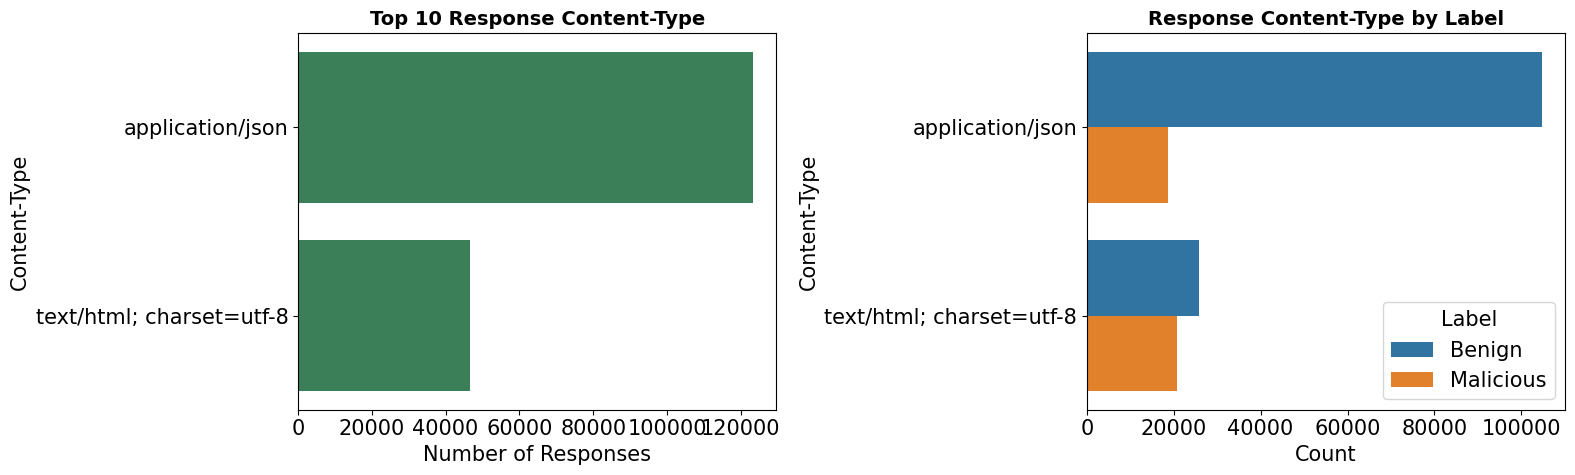

In [144]:
# --- Analysis of Response Content-Type Distribution ---

# Get the 10 most frequent response Content-Type values
content_type_counts = data_viz['res_Content-Type'].value_counts().head(10)
content_type_df = content_type_counts.reset_index()
content_type_df.columns = ['Content-Type', 'Count']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Horizontal bar chart: Top 10 Content-Types by occurrence
sns.barplot(
    data=content_type_df,
    x='Count',
    y='Content-Type',
    color='seagreen',
    ax=axes[0]
)
axes[0].set_title("Top 10 Response Content-Type", fontsize=14, weight='bold')
axes[0].set_xlabel("Number of Responses")
axes[0].set_ylabel("Content-Type")

# 2. Stacked bar chart: Content-Type distribution by label (Benign vs Malicious)
sns.countplot(
    data=data_viz,
    y='res_Content-Type',
    hue='label',
    order=data_viz['res_Content-Type'].value_counts().index,
    ax=axes[1]
)
axes[1].set_title("Response Content-Type by Label", fontsize=14, weight='bold')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Content-Type")
axes[1].legend(title="Label", labels=["Benign", "Malicious"])

plt.tight_layout()
plt.show()

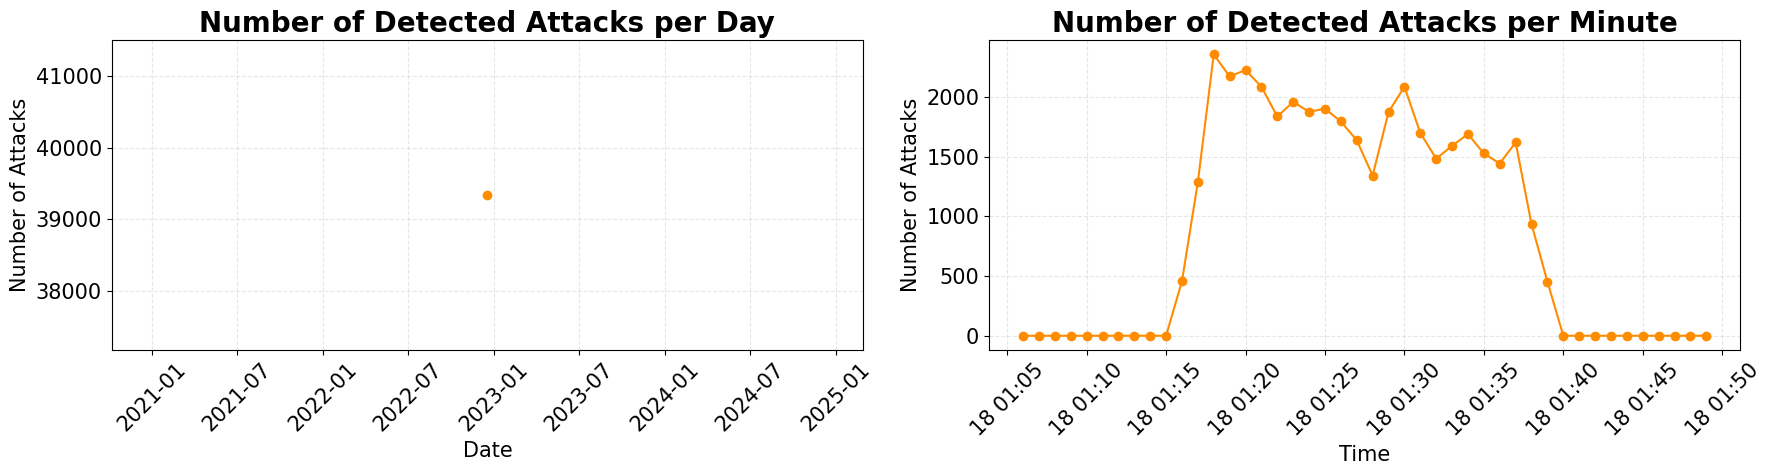

In [145]:
# --- Temporal Analysis: Detected Attacks by Day and Minute ---

# Convert the 'req_Date' column to datetime format, coercing errors to NaT
req_date_dt = pd.to_datetime(data_viz['req_Date'], errors='coerce')

# Create a boolean mask to identify rows with detected attacks
attack_mask = data_viz['Attack_Tag'].notna()

# Extract the dates for attack entries only
attack_dates = req_date_dt[attack_mask]

# Group by day: count the number of detected attacks per day
attacks_by_day = attack_dates.groupby(attack_dates.dt.date).size()

# Group by minute: count the number of detected attacks per minute
attack_minutes = req_date_dt.dt.floor('min')[attack_mask]
attacks_by_minute = attack_minutes.groupby(attack_minutes).size()

# Build a continuous minute-level time series to fill any missing minutes with zero
if not attacks_by_minute.empty:
    start = attacks_by_minute.index.min() - pd.Timedelta(minutes=10)
    end = attacks_by_minute.index.max() + pd.Timedelta(minutes=10)
    full_range = pd.date_range(start=start, end=end, freq='min')
    full_attacks = pd.Series(0, index=full_range)
    full_attacks.update(attacks_by_minute)
else:
    # If there are no attacks, create an empty time series
    full_range = pd.date_range(pd.Timestamp.now(), periods=1, freq='min')
    full_attacks = pd.Series(0, index=full_range)

# Create subplots: one for daily counts, one for minute-level counts
fig, axes = plt.subplots(1, 2, figsize=(18, 5))


# Optional: Set global font size defaults for matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,      # For axes titles
    'axes.labelsize': 15,      # For axis labels
    'xtick.labelsize': 15,     # For x-tick labels
    'ytick.labelsize': 15,     # For y-tick labels
    'legend.fontsize': 15,     # For legend text
    'font.size': 15,           # General font size
})

# Plot: Number of detected attacks per day
axes[0].plot(attacks_by_day.index, attacks_by_day.values, marker='o', linestyle='-', color='darkorange')
axes[0].set_title("Number of Detected Attacks per Day", fontsize=20, weight='bold')
axes[0].set_xlabel("Date", fontsize=15)
axes[0].set_ylabel("Number of Attacks", fontsize=15)
axes[0].tick_params(axis='x', labelsize=15, rotation=45)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot: Number of detected attacks per minute (continuous series)
axes[1].plot(full_attacks.index, full_attacks.values, marker='o', linestyle='-', color='darkorange')
axes[1].set_title("Number of Detected Attacks per Minute", fontsize=20, weight='bold')
axes[1].set_xlabel("Time", fontsize=15)
axes[1].set_ylabel("Number of Attacks", fontsize=15)
axes[1].tick_params(axis='x', labelsize=15, rotation=45)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

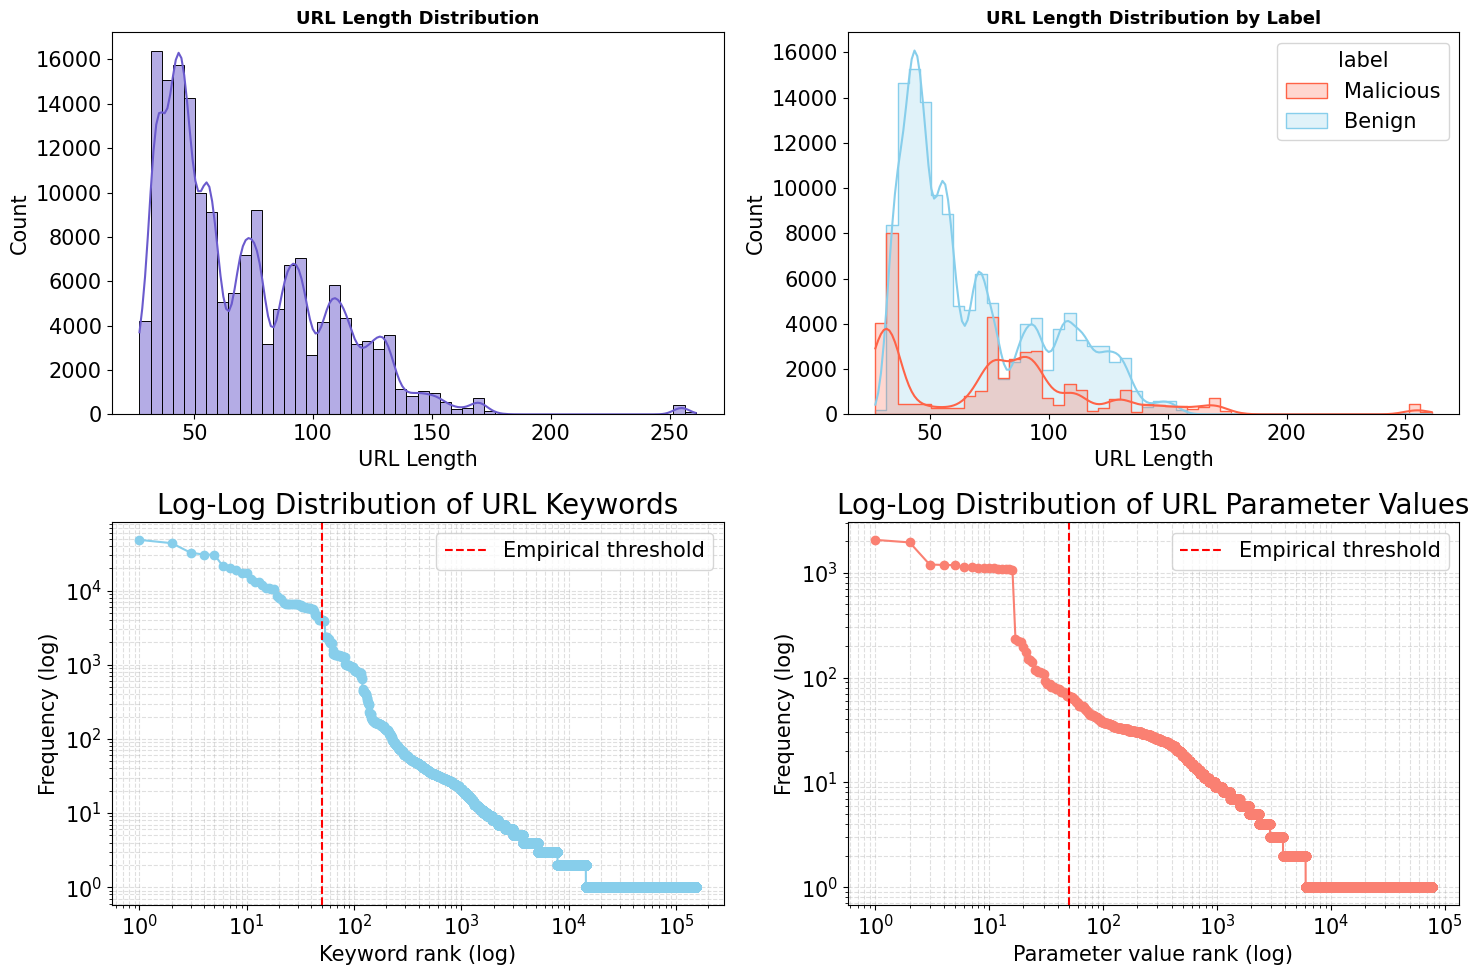

In [146]:
# --- Extracts structural and payload features from URLs (length, keywords, parameters) ---

# --- Mapping for label values to names ---
label_map = {0: "Benign", 1: "Malicious"}

# --- Function to extract all keywords from the URL (path and query) ---
def extract_keywords_from_url(url):
    """
    Extracts all word-like tokens from the path and query parts of a URL.
    Returns a list of lowercase keywords.
    """
    try:
        decoded_url = unquote(url)
        path = urlparse(decoded_url).path
        query = urlparse(decoded_url).query
        all_parts = path + ' ' + query
        tokens = re.findall(r'\b\w+\b', all_parts.lower())
        return tokens
    except Exception:
        return []

# --- Function to extract parameter values from URL query string ---
def extract_param_values_kv(url):
    """
    Extracts all parameter values from the query part of a URL.
    Returns a list of parameter values as strings.
    """
    try:
        parsed = urlparse(str(url))
        params = parse_qs(parsed.query)
        return [v for values in params.values() for v in values]
    except Exception:
        return []

# --- Prepare temporary columns for visualization (do NOT modify data_viz) ---
url_length = data_viz['url'].astype(str).apply(len)
url_keywords = data_viz['url'].dropna().apply(extract_keywords_from_url)
param_values = data_viz['url'].apply(extract_param_values_kv)

# --- Flatten lists for log-log distribution analysis ---
flat_keywords = [token for sublist in url_keywords for token in sublist]
flat_param_values = [v for sublist in param_values for v in sublist if v]

keyword_counts = Counter(flat_keywords)
sorted_keywords = keyword_counts.most_common()

param_value_counts = Counter(flat_param_values)
sorted_param_values = param_value_counts.most_common()

# --- Plotting: 2x2 grid of visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.36, wspace=0.22)

# (1,1) Simple distribution of URL lengths
sns.histplot(
    x=url_length,
    bins=50,
    kde=True,
    color='slateblue',
    ax=axes[0, 0]
)
axes[0, 0].set_title("URL Length Distribution", fontsize=13, weight='bold')
axes[0, 0].set_xlabel("URL Length")
axes[0, 0].set_ylabel("Count")

# (1,2) URL length distribution by label
sns.histplot(
    x=url_length,
    hue=data_viz['label'].map(label_map),
    bins=50,
    kde=True,
    element="step",
    common_norm=False,
    palette={"Benign": "skyblue", "Malicious": "tomato"},
    ax=axes[0, 1]
)
axes[0, 1].set_title("URL Length Distribution by Label", fontsize=13, weight='bold')
axes[0, 1].set_xlabel("URL Length")
axes[0, 1].set_ylabel("Count")

# (2,1) Log-log distribution of extracted keywords
if sorted_keywords:
    counts_keywords = [count for _, count in sorted_keywords]
    axes[1, 0].plot(range(1, len(counts_keywords) + 1), counts_keywords, marker='o', color='skyblue')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_xlabel("Keyword rank (log)")
    axes[1, 0].set_ylabel("Frequency (log)")
    axes[1, 0].set_title("Log-Log Distribution of URL Keywords")
    axes[1, 0].axvline(x=50, color='red', linestyle='--', label='Empirical threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, which='both', linestyle='--', alpha=0.4)
else:
    axes[1, 0].set_visible(False)

# (2,2) Log-log distribution of parameter values (payloads)
if sorted_param_values:
    counts_param = [count for _, count in sorted_param_values]
    axes[1, 1].plot(range(1, len(counts_param) + 1), counts_param, marker='o', color='salmon')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_xlabel("Parameter value rank (log)")
    axes[1, 1].set_ylabel("Frequency (log)")
    axes[1, 1].set_title("Log-Log Distribution of URL Parameter Values")
    axes[1, 1].axvline(x=50, color='red', linestyle='--', label='Empirical threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.4)
else:
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

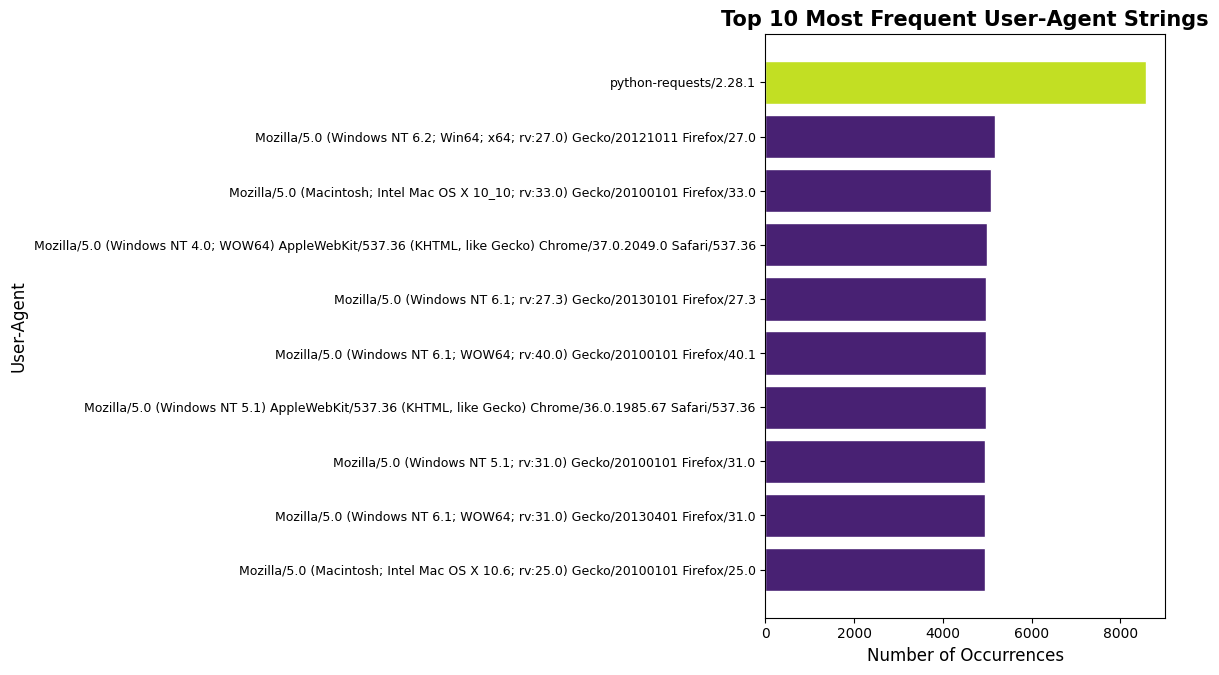

In [147]:
# --- Top User-Agent Analysis: Horizontal Bar Chart ---

# Get the 10 most frequent User-Agent values in the dataset
top_agents = data_viz['req_User-Agent'].value_counts().nlargest(10)
top_agents_df = top_agents.reset_index()
top_agents_df.columns = ['User-Agent', 'Count']

# Generate a color gradient (viridis colormap) based on the frequency counts
norm = plt.Normalize(top_agents_df['Count'].min(), top_agents_df['Count'].max())
colors = sns.color_palette("viridis", n_colors=len(top_agents_df))
mapped_colors = [colors[int(norm(val) * (len(colors) - 1))] for val in top_agents_df['Count']]

# Plot a horizontal bar chart showing the frequency of each User-Agent
plt.figure(figsize=(12, 7))
plt.barh(
    top_agents_df['User-Agent'],
    top_agents_df['Count'],
    color=mapped_colors,
    edgecolor='white'
)

plt.title("Top 10 Most Frequent User-Agent Strings", fontsize=15, weight='bold')
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("User-Agent", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()  # Ensures the most frequent User-Agent appears at the top
plt.tight_layout()
plt.show()


<ipython-input-148-cc89cc70884b>:53: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



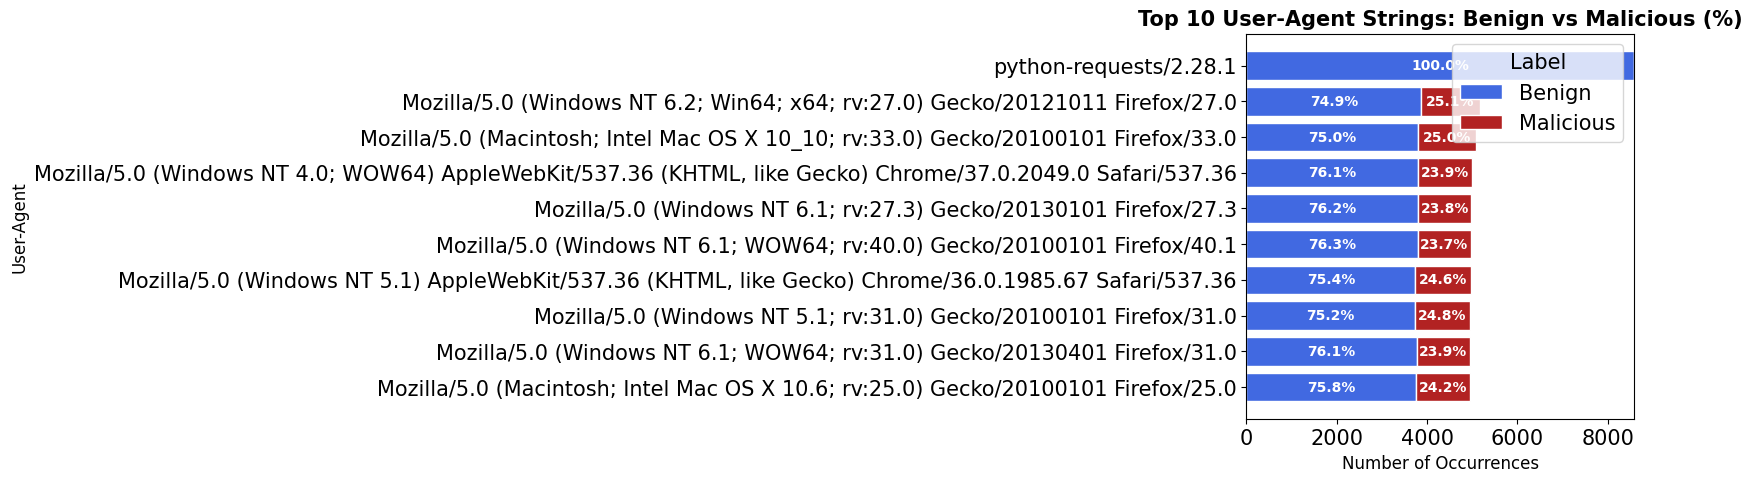

In [148]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Map numeric labels to string if not already done
label_map = {0: "Benign", 1: "Malicious"}
data_viz['label_name'] = data_viz['label'].map(label_map)

# Top 10 User-Agents
top_agents = data_viz['req_User-Agent'].value_counts().nlargest(10).index
df_top = data_viz[data_viz['req_User-Agent'].isin(top_agents)]

# Group by User-Agent and label, count occurrences
pivot_df = (
    df_top
    .groupby(['req_User-Agent', 'label_name'])
    .size()
    .unstack(fill_value=0)
    .reindex(top_agents)
)

# Compute percentages
percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Colors: Benign - blue, Malicious - red
colors = ['royalblue', 'firebrick']

# Plot
plt.figure(figsize=(5, 5))
bars = plt.barh(pivot_df.index, pivot_df['Benign'], color=colors[0], edgecolor='white', label='Benign')
bars2 = plt.barh(pivot_df.index, pivot_df['Malicious'], left=pivot_df['Benign'], color=colors[1], edgecolor='white', label='Malicious')

# Annotate percentages on the bars
for i, (benign, malicious) in enumerate(zip(percent_df['Benign'], percent_df['Malicious'])):
    total = benign + malicious
    # Benign %
    if benign > 0:
        plt.text(benign/100*pivot_df.sum(axis=1).iloc[i]/2, i, f"{benign:.1f}%", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
    # Malicious %
    if malicious > 0:
        plt.text(
            pivot_df['Benign'].iloc[i] + malicious/100*pivot_df.sum(axis=1).iloc[i]/2,
            i,
            f"{malicious:.1f}%",
            va='center', ha='center', color='white', fontsize=10, fontweight='bold'
        )

plt.title("Top 10 User-Agent Strings: Benign vs Malicious (%)", fontsize=15, weight='bold')
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("User-Agent", fontsize=12)
plt.legend(title="Label")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


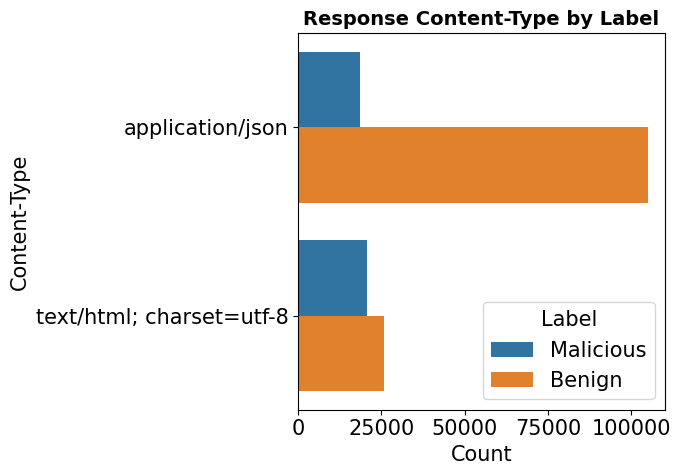

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numeric labels to string (if needed)
label_map = {0: "Benign", 1: "Malicious"}
data_viz['label_name'] = data_viz['label'].map(label_map)

# Get the order of Content-Types by frequency
content_type_order = data_viz['res_Content-Type'].value_counts().index

plt.figure(figsize=(7, 5))
sns.countplot(
    data=data_viz,
    y='res_Content-Type',
    hue='label_name',  # Use the mapped labels
    order=content_type_order
)
plt.title("Response Content-Type by Label", fontsize=14, weight='bold')
plt.xlabel("Count")
plt.ylabel("Content-Type")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


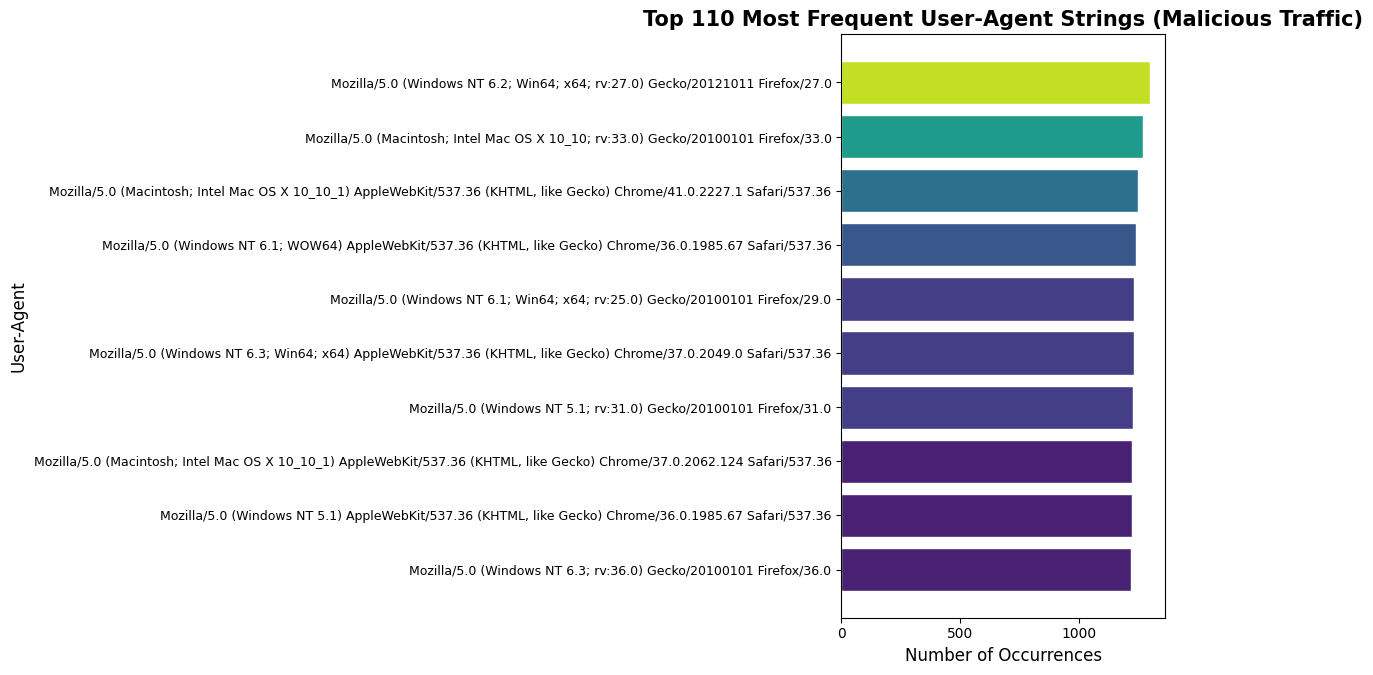

In [150]:
# --- Top User-Agents in Malicious Requests: Horizontal Bar Chart ---

# Filter the dataset to keep only User-Agent values for malicious (attack) requests
malicious_agents = data_viz[data_viz['label'] == 1]['req_User-Agent']

# Get the 10 most frequent User-Agent values among malicious requests
top_agents = malicious_agents.value_counts().nlargest(10)
top_agents_df = top_agents.reset_index()
top_agents_df.columns = ['User-Agent', 'Count']

# Generate a color gradient (viridis colormap) based on occurrence counts
norm = plt.Normalize(top_agents_df['Count'].min(), top_agents_df['Count'].max())
colors = sns.color_palette("viridis", n_colors=len(top_agents_df))
mapped_colors = [colors[int(norm(val) * (len(colors) - 1))] for val in top_agents_df['Count']]

# Plot a horizontal bar chart for User-Agent frequency in malicious traffic
plt.figure(figsize=(12, 7))
plt.barh(
    top_agents_df['User-Agent'],
    top_agents_df['Count'],
    color=mapped_colors,
    edgecolor='white'
)

plt.title("Top 110 Most Frequent User-Agent Strings (Malicious Traffic)", fontsize=15, weight='bold')
plt.xlabel("Number of Occurrences", fontsize=12)
plt.ylabel("User-Agent", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()  # Ensures the most frequent User-Agent appears at the top
plt.tight_layout()
plt.show()


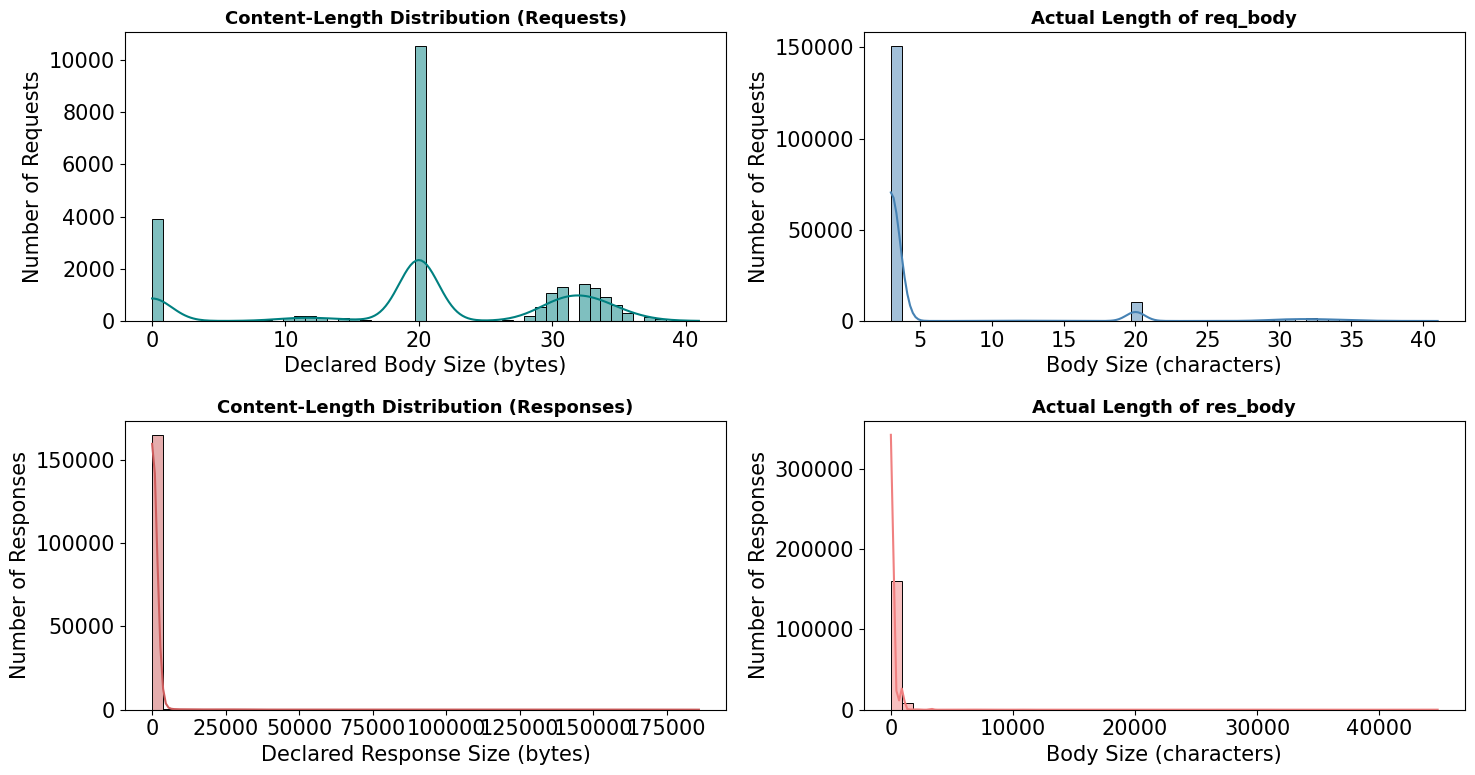

In [151]:
# --- Content-Length and Body Size Analysis for HTTP Requests and Responses ---

# Convert declared Content-Length fields to numeric values, coercing errors to NaN
req_content_length = pd.to_numeric(data_viz['req_Content-Length'], errors='coerce')
res_content_length = pd.to_numeric(data_viz['res_Content-Length'], errors='coerce')

# Calculate the actual length (number of characters) of the request and response bodies
req_body_length = data_viz['req_body'].astype(str).apply(len)
res_body_length = data_viz['res_body'].astype(str).apply(len)

# Create a 2x2 grid of subplots for visualizing content length and body size distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# (Top-left) Histogram: Declared Content-Length in requests
sns.histplot(
    x=req_content_length.dropna(),
    bins=50,
    kde=True,
    color='teal',
    ax=axes[0, 0]
)
axes[0, 0].set_title("Content-Length Distribution (Requests)", fontsize=13, weight='bold')
axes[0, 0].set_xlabel("Declared Body Size (bytes)")
axes[0, 0].set_ylabel("Number of Requests")

# (Top-right) Histogram: Actual request body length (characters)
sns.histplot(
    x=req_body_length,
    bins=50,
    kde=True,
    color='steelblue',
    ax=axes[0, 1]
)
axes[0, 1].set_title("Actual Length of req_body", fontsize=13, weight='bold')
axes[0, 1].set_xlabel("Body Size (characters)")
axes[0, 1].set_ylabel("Number of Requests")

# (Bottom-left) Histogram: Declared Content-Length in responses
sns.histplot(
    x=res_content_length.dropna(),
    bins=50,
    kde=True,
    color='indianred',
    ax=axes[1, 0]
)
axes[1, 0].set_title("Content-Length Distribution (Responses)", fontsize=13, weight='bold')
axes[1, 0].set_xlabel("Declared Response Size (bytes)")
axes[1, 0].set_ylabel("Number of Responses")

# (Bottom-right) Histogram: Actual response body length (characters)
sns.histplot(
    x=res_body_length,
    bins=50,
    kde=True,
    color='lightcoral',
    ax=axes[1, 1]
)
axes[1, 1].set_title("Actual Length of res_body", fontsize=13, weight='bold')
axes[1, 1].set_xlabel("Body Size (characters)")
axes[1, 1].set_ylabel("Number of Responses")

plt.tight_layout()
plt.show()


<ipython-input-152-e31d93e40078>:85: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-152-e31d93e40078>:97: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




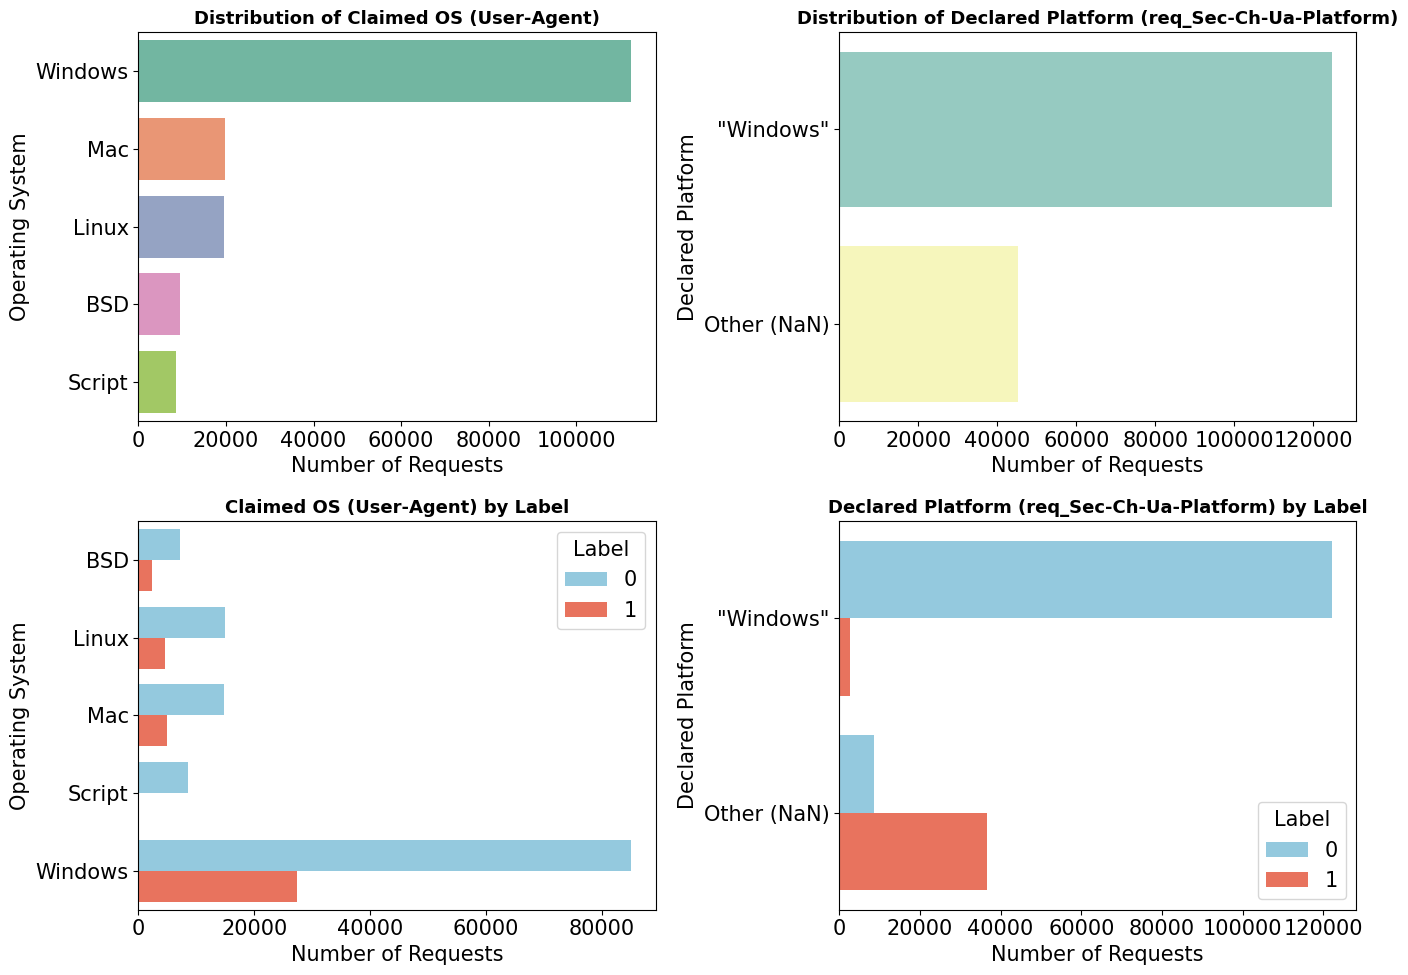

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Mapping for label values ---
label_map = {0: "Benign", 1: "Malicious"}

# --- Function to infer the claimed operating system from a User-Agent string ---
def extract_claimed_os(user_agent):
    """
    Infers the operating system or client type from a User-Agent string.
    Returns standardized OS names or 'Other'.
    """
    ua = str(user_agent).lower()
    if ua.startswith('python-requests'):
        return 'Script'
    elif 'windows' in ua:
        return 'Windows'
    elif 'android' in ua:
        return 'Android'
    elif 'iphone' in ua or 'ios' in ua:
        return 'iOS'
    elif 'macintosh' in ua or 'mac os' in ua:
        return 'Mac'
    elif 'openbsd' in ua or 'freebsd' in ua or 'netbsd' in ua:
        return 'BSD'
    elif 'linux' in ua:
        return 'Linux'
    else:
        return 'Other'

# --- Extract temporary columns for visualization (do NOT modify data_viz) ---

# 1. Claimed OS inferred from User-Agent
claimed_os = data_viz['req_User-Agent'].apply(extract_claimed_os)

# 2. Declared platform from 'req_Sec-Ch-Ua-Platform'
declared_platform = (
    data_viz['req_Sec-Ch-Ua-Platform']
    .fillna('Other')
    .replace({'': 'Other'})
)

# --- Prepare OS distribution data ---
claimed_os_counts = claimed_os.value_counts(dropna=False).reset_index()
claimed_os_counts.columns = ['OS', 'Count']

# --- Prepare OS by label data ---
os_by_label = (
    pd.DataFrame({
        'claimed_os': claimed_os,
        'label': data_viz['label']
    })
    .groupby(['claimed_os', 'label'])
    .size()
    .reset_index(name='Count')
)

# --- Prepare declared platform distribution data ---
platform_counts = (
    declared_platform
    .replace({np.nan: 'Other (NaN)', 'Other': 'Other (NaN)'})
    .value_counts()
    .reset_index()
)
platform_counts.columns = ['Platform', 'Count']

# --- Prepare platform by label data ---
platform_by_label = (
    pd.DataFrame({
        'declared_platform': declared_platform.replace({np.nan: 'Other (NaN)', 'Other': 'Other (NaN)'}),
        'label': data_viz['label']
    })
    .groupby(['declared_platform', 'label'])
    .size()
    .reset_index(name='Count')
)

# --- Plot all in a 2x2 grid ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.28, wspace=0.22)

# Plot 1: Distribution of claimed OS (User-Agent)
sns.barplot(
    data=claimed_os_counts,
    y='OS',
    x='Count',
    palette='Set2',
    ax=axes[0, 0]
)
axes[0, 0].set_title("Distribution of Claimed OS (User-Agent)", fontsize=13, weight='bold')
axes[0, 0].set_xlabel("Number of Requests")
axes[0, 0].set_ylabel("Operating System")

# Plot 2: Distribution of declared platform
sns.barplot(
    data=platform_counts,
    y='Platform',
    x='Count',
    palette='Set3',
    ax=axes[0, 1]
)
axes[0, 1].set_title("Distribution of Declared Platform (req_Sec-Ch-Ua-Platform)", fontsize=13, weight='bold')
axes[0, 1].set_xlabel("Number of Requests")
axes[0, 1].set_ylabel("Declared Platform")

# Plot 3: OS by label
sns.barplot(
    data=os_by_label,
    y='claimed_os',
    x='Count',
    hue='label',
    palette=['skyblue', 'tomato'],
    ax=axes[1, 0]
)
axes[1, 0].set_title("Claimed OS (User-Agent) by Label", fontsize=13, weight='bold')
axes[1, 0].set_xlabel("Number of Requests")
axes[1, 0].set_ylabel("Operating System")
axes[1, 0].legend(title='Label')

# Plot 4: Declared platform by label
sns.barplot(
    data=platform_by_label,
    y='declared_platform',
    x='Count',
    hue='label',
    palette=['skyblue', 'tomato'],
    ax=axes[1, 1]
)
axes[1, 1].set_title("Declared Platform (req_Sec-Ch-Ua-Platform) by Label", fontsize=13, weight='bold')
axes[1, 1].set_xlabel("Number of Requests")
axes[1, 1].set_ylabel("Declared Platform")
axes[1, 1].legend(title='Label')

plt.tight_layout()
plt.show()


Tracked languages: ['de', 'en', 'unknown', 'he']


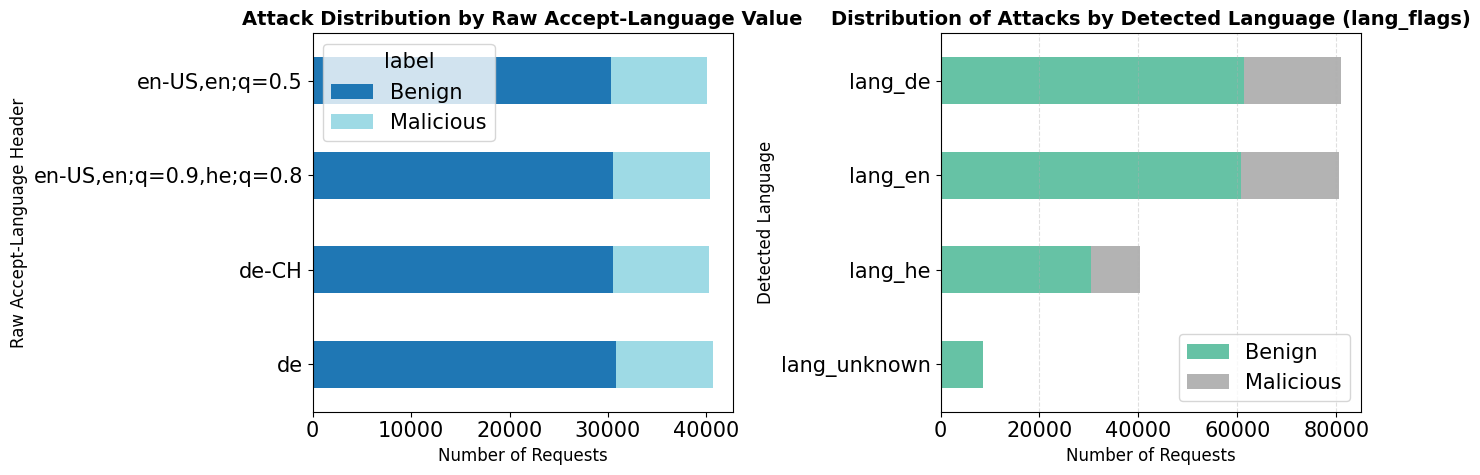

In [153]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Function to extract a list of languages from the Accept-Language header ---
def extract_all_languages(lang_str):
    """
    Extracts a list of language codes from an Accept-Language header.
    Removes duplicates, ignores q-values/region variants, and returns 'unknown' if missing.
    """
    if pd.isna(lang_str):
        return ['unknown']
    lang_str = lang_str.lower()
    return list({
        re.split(';|,', part.strip())[0].split('-')[0]
        for part in lang_str.split(',')
    })

# --- Create a temporary series with language lists ---
language_list = data_viz['req_Accept-Language'].apply(extract_all_languages)

# --- Function to generate binary flags for each language (returns a DataFrame of flags) ---
def generate_language_flags(language_list, threshold=100):
    """
    For each detected language above the threshold, create a binary flag column.
    Returns (flags_df, languages_tracked).
    """
    lang_counter = Counter(lang for langs in language_list for lang in langs)
    languages_to_track = [lang for lang, count in lang_counter.items() if count > threshold]
    flags = {
        f'lang_{lang}': language_list.apply(lambda lst: int(lang in lst))
        for lang in languages_to_track
    }
    return pd.DataFrame(flags), languages_to_track

# --- Generate the language flags DataFrame and get tracked languages ---
lang_flags_df, tracked_langs = generate_language_flags(language_list)
print(f"Tracked languages: {tracked_langs}")

# --- (1) Top 10 most frequent raw Accept-Language values (by label) ---
top_lang_raw = data_viz['req_Accept-Language'].fillna('unknown').value_counts().head(10).index
lang_raw_grouped = (
    data_viz[data_viz['req_Accept-Language'].isin(top_lang_raw)]
    .groupby(['req_Accept-Language', 'label'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'Benign', 1: 'Malicious'})
    .sort_values(by=['Benign', 'Malicious'], ascending=False)
)

# --- (2) Language flag statistics per detected language ---
lang_flag_stats = None
if not lang_flags_df.empty:
    # Merge flags with label for grouped stats
    label_col = data_viz['label'].reset_index(drop=True)
    merged = pd.concat([lang_flags_df.reset_index(drop=True), label_col], axis=1)
    lang_flag_stats = merged.groupby('label')[lang_flags_df.columns].sum().T
    lang_flag_stats.columns = ['Benign', 'Malicious']
    lang_flag_stats['Total'] = lang_flag_stats.sum(axis=1)
    lang_flag_stats = lang_flag_stats.sort_values('Total', ascending=True)

# --- Subplots: Accept-Language distribution and language flags ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) Plot: Attack Distribution by Raw Accept-Language Value
lang_raw_grouped.plot(
    kind='barh',
    stacked=True,
    ax=axes[0],
    colormap='tab20',
    legend=True
)
axes[0].set_title("Attack Distribution by Raw Accept-Language Value", fontsize=14, weight='bold')
axes[0].set_xlabel("Number of Requests", fontsize=12)
axes[0].set_ylabel("Raw Accept-Language Header", fontsize=12)

# (2) Plot: Distribution of attacks by detected language flags (if available)
if lang_flag_stats is not None and not lang_flag_stats.empty:
    lang_flag_stats[['Benign', 'Malicious']].plot(
        kind='barh',
        stacked=True,
        colormap='Set2',
        ax=axes[1],
        legend=True
    )
    axes[1].set_title("Distribution of Attacks by Detected Language (lang_flags)", fontsize=14, weight='bold')
    axes[1].set_xlabel("Number of Requests", fontsize=12)
    axes[1].set_ylabel("Detected Language", fontsize=12)
    axes[1].grid(axis='x', linestyle='--', alpha=0.4)
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()


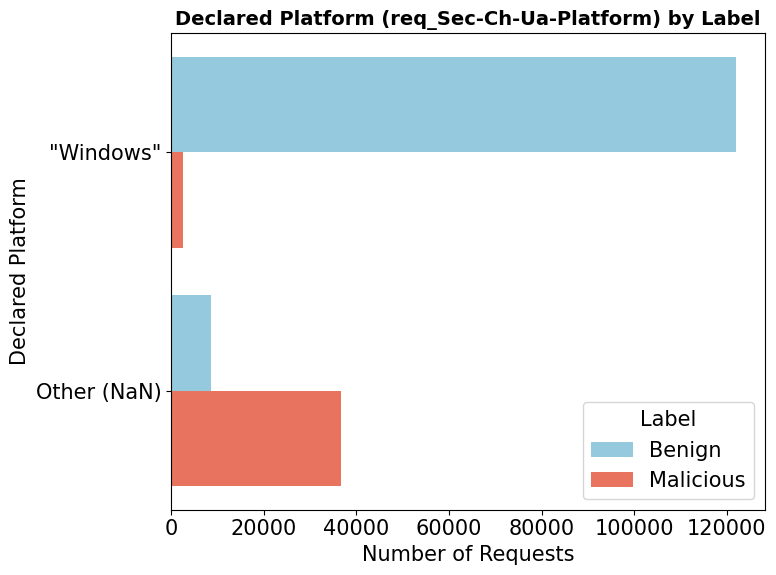

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map label values to names
label_map = {0: "Benign", 1: "Malicious"}
platform_by_label_plot = platform_by_label.copy()
platform_by_label_plot['label'] = platform_by_label_plot['label'].map(label_map)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=platform_by_label_plot,
    y='declared_platform',
    x='Count',
    hue='label',
    palette=['skyblue', 'tomato']
)
plt.title("Declared Platform (req_Sec-Ch-Ua-Platform) by Label", fontsize=14, weight='bold')
plt.xlabel("Number of Requests")
plt.ylabel("Declared Platform")
plt.legend(title='Label')
plt.tight_layout()
plt.show()


<ipython-input-155-26a8d7d9aece>:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-155-26a8d7d9aece>:84: UserWarning:

The figure layout has changed to tight



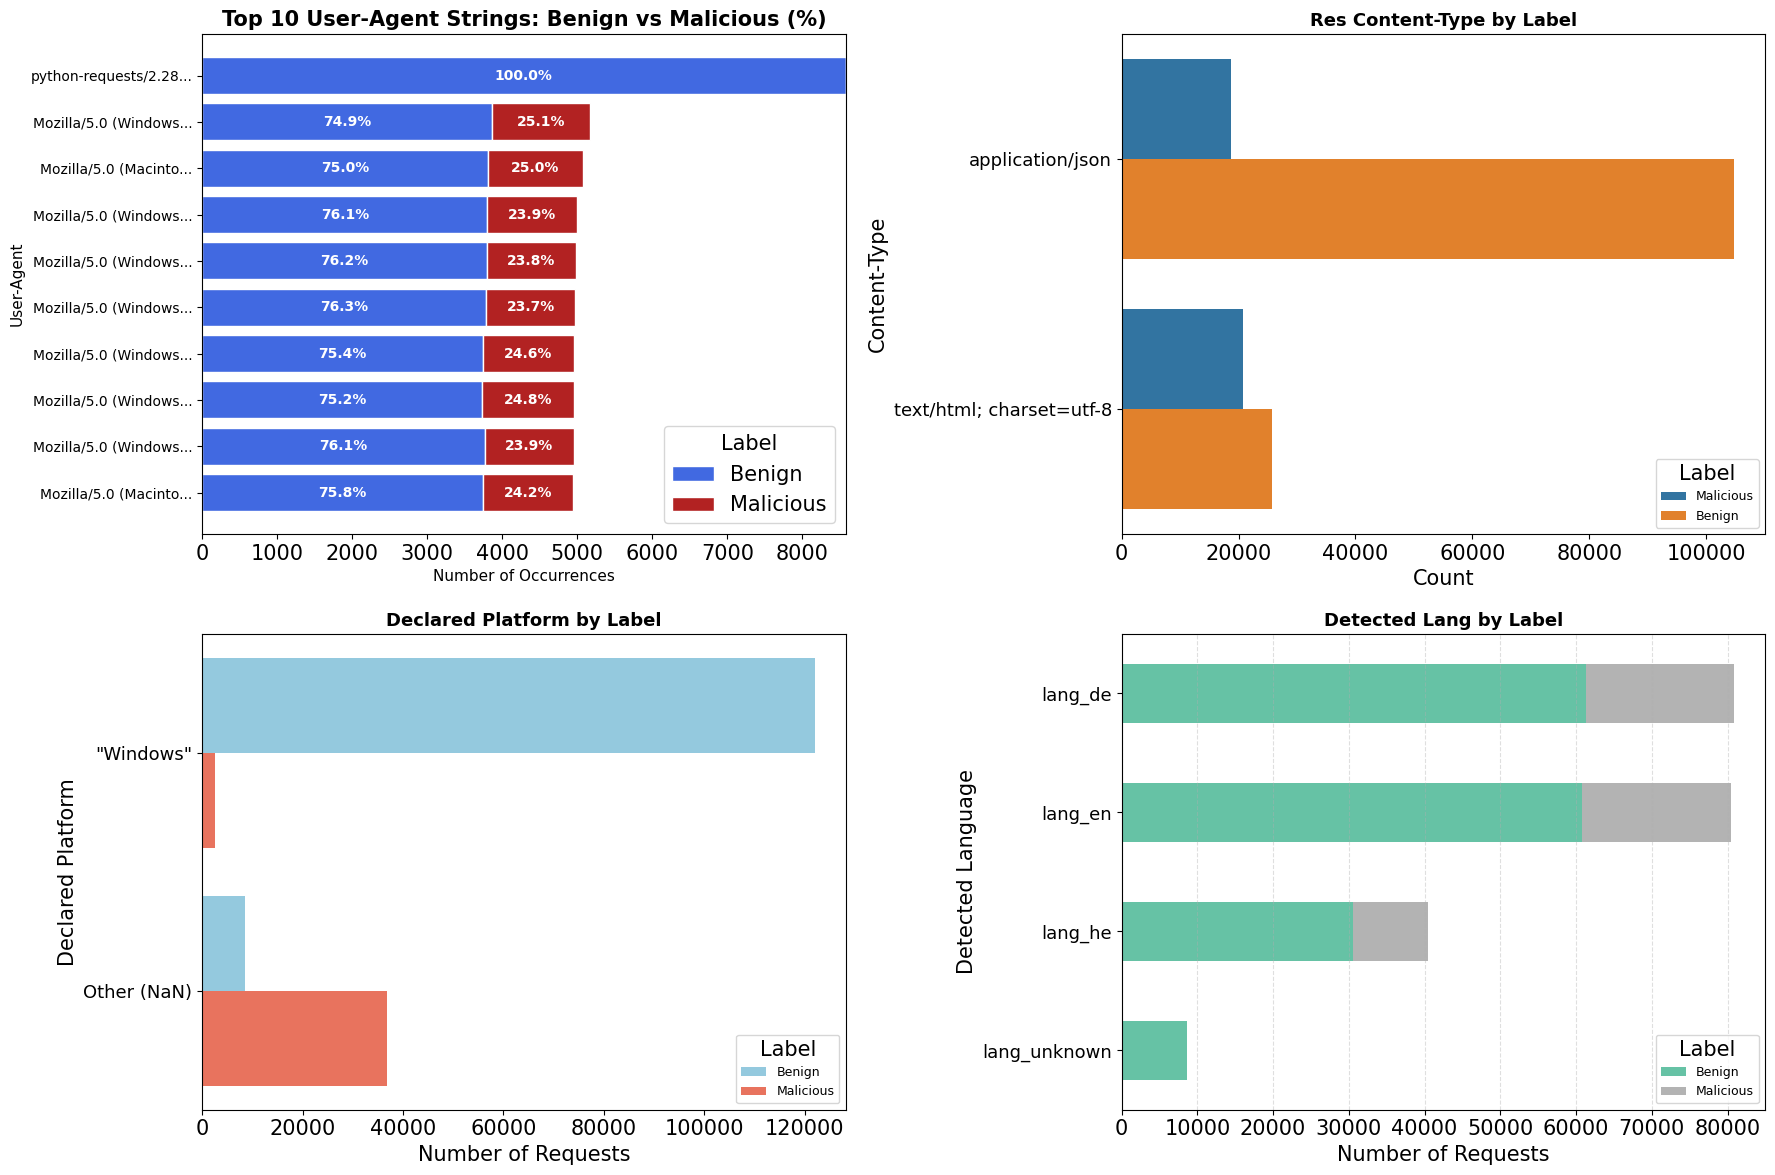

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(constrained_layout=True, figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[2.1, 2])

# --------- (0,0) : Top 10 User-Agent Strings ---------
ax0 = fig.add_subplot(gs[0, 0])
bars = ax0.barh(pivot_df.index, pivot_df['Benign'], color='royalblue', edgecolor='white', label='Benign')
bars2 = ax0.barh(pivot_df.index, pivot_df['Malicious'], left=pivot_df['Benign'], color='firebrick', edgecolor='white', label='Malicious')
for i, (benign, malicious) in enumerate(zip(percent_df['Benign'], percent_df['Malicious'])):
    if pivot_df['Benign'].iloc[i] > 0:
        ax0.text(pivot_df['Benign'].iloc[i]/2, i, f"{benign:.1f}%", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
    if pivot_df['Malicious'].iloc[i] > 0:
        ax0.text(
            pivot_df['Benign'].iloc[i] + pivot_df['Malicious'].iloc[i]/2, i,
            f"{malicious:.1f}%",
            va='center', ha='center', color='white', fontsize=10, fontweight='bold'
        )
ax0.set_title("Top 10 User-Agent Strings: Benign vs Malicious (%)", fontsize=15, weight='bold')
ax0.set_xlabel("Number of Occurrences", fontsize=11)
ax0.set_ylabel("User-Agent", fontsize=11)
ax0.legend(title="Label")
ax0.invert_yaxis()
# Troncature affichée sur l'axe Y
maxlen = 20
short_labels = [ua[:maxlen] + '...' if len(ua) > maxlen else ua for ua in pivot_df.index]
ax0.set_yticklabels(short_labels, fontsize=10)

# --------- (0,1) : Response Content-Type by Label ---------
ax1 = fig.add_subplot(gs[0, 1])
sns.countplot(
    data=data_viz,
    y='res_Content-Type',
    hue='label_name',
    order=content_type_order,
    ax=ax1
)
ax1.set_title("Res Content-Type by Label", fontsize=13, weight='bold')
ax1.set_xlabel("Count")
ax1.set_ylabel("Content-Type")
ax1.legend(title="Label", loc='lower right', fontsize=9)
for label in ax1.get_yticklabels():
    label.set_fontsize(13)

# --------- (1,0) : Declared Platform by Label ---------
ax2 = fig.add_subplot(gs[1, 0])
sns.barplot(
    data=platform_by_label_plot,
    y='declared_platform',
    x='Count',
    hue='label',
    palette=['skyblue', 'tomato'],
    ax=ax2
)
ax2.set_title("Declared Platform by Label", fontsize=13, weight='bold')
ax2.set_xlabel("Number of Requests")
ax2.set_ylabel("Declared Platform")
ax2.legend(title='Label', loc='lower right', fontsize=9)
for label in ax2.get_yticklabels():
    label.set_fontsize(13)

# --------- (1,1) : Detected Language by Label (lang_flags) ---------
ax3 = fig.add_subplot(gs[1, 1])
if lang_flag_stats is not None and not lang_flag_stats.empty:
    lang_flag_stats[['Benign', 'Malicious']].plot(
        kind='barh',
        stacked=True,
        colormap='Set2',
        legend=True,
        ax=ax3
    )
    ax3.set_title("Detected Lang by Label", fontsize=13, weight='bold')
    ax3.set_xlabel("Number of Requests")
    ax3.set_ylabel("Detected Language")
    ax3.grid(axis='x', linestyle='--', alpha=0.4)
    ax3.legend(title='Label', loc='lower right', fontsize=9)
    for label in ax3.get_yticklabels():
        label.set_fontsize(13)
else:
    ax3.axis('off')
    ax3.text(0.5, 0.5, "No language flag statistics to plot.", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


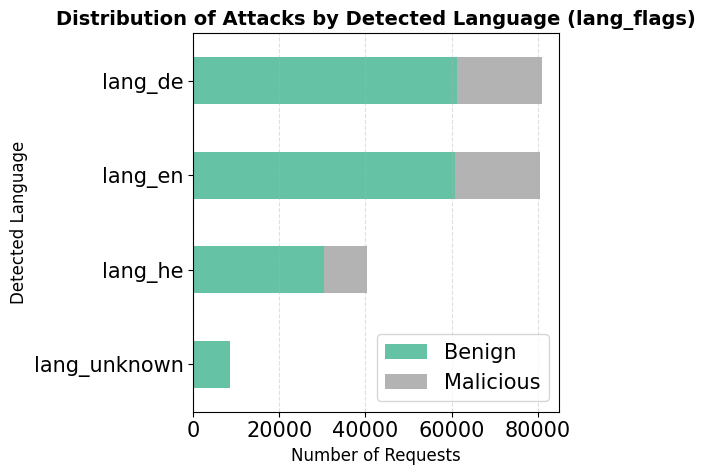

In [156]:
import matplotlib.pyplot as plt

# Only plot if stats exist and not empty
if lang_flag_stats is not None and not lang_flag_stats.empty:
    plt.figure(figsize=(6, 5))
    lang_flag_stats[['Benign', 'Malicious']].plot(
        kind='barh',
        stacked=True,
        colormap='Set2',
        legend=True,
        ax=plt.gca()
    )
    plt.title("Distribution of Attacks by Detected Language (lang_flags)", fontsize=14, weight='bold')
    plt.xlabel("Number of Requests", fontsize=12)
    plt.ylabel("Detected Language", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("No language flag statistics to plot.")


In [157]:
import json
from urllib.parse import urlparse, parse_qs

# --- Helper: Extract all parameter values from URL ---
def extract_param_values(url):
    """Extract all parameter values from the URL query string as a list."""
    try:
        params = parse_qs(urlparse(str(url)).query)
        return [v for values in params.values() for v in values]
    except Exception:
        return []

# --- Helper: Extract all values from a dict or list (for JSON bodies) ---
def extract_json_values(obj):
    values = []
    if isinstance(obj, dict):
        for v in obj.values():
            values.extend(extract_json_values(v))
    elif isinstance(obj, list):
        for v in obj:
            values.extend(extract_json_values(v))
    else:
        if obj is not None:
            values.append(str(obj))
    return values

# --- Helper: Parse body as JSON (returns dict or empty dict) ---
def body_to_json(row):
    try:
        return json.loads(row)
    except Exception:
        return {}

# --- Helper: Extract all parameter names from URL query ---
def extract_param_names(url):
    try:
        params = parse_qs(urlparse(str(url)).query)
        return list(params.keys())
    except Exception:
        return []

# --- Helper: Extract all keys from JSON (for parameter names in body) ---
def json_param_names(obj):
    keys = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            keys.append(k)
            keys.extend(json_param_names(v))
    elif isinstance(obj, list):
        for item in obj:
            keys.extend(json_param_names(item))
    return keys

# --- Apply helpers to your DataFrame for value/name lists ---
body_param_values = data_viz['req_body'].apply(lambda x: extract_json_values(body_to_json(x)))
url_param_values = data_viz['url'].apply(extract_param_values)

body_param_names = data_viz['req_body'].apply(lambda x: json_param_names(body_to_json(x)))
url_param_names = data_viz['url'].apply(extract_param_names)


In [158]:
# --- Structural Feature Extraction (URL, Parameters, Encoding, etc.) ---

# Initialize a new DataFrame for feature engineering, using the same index as data_viz
data_vizcopy = pd.DataFrame(index=data_viz.index)

# Identify all columns representing CRS severity scores
severity_cols = [col for col in data_viz.columns if col.startswith('severity_')]

# Start with Attack_Tag, all severity columns, and alert_count as the base features
data_vizcopy = data_viz[['Attack_Tag'] + severity_cols + ['alert_count']].copy()

# ============================
# --- Structural Features (Direct HTTP Request Structure) ---
# ============================

# --- Shannon entropy calculation for a string ---
def shannon_entropy(s):
    """Calculate the Shannon entropy of a string."""
    if not isinstance(s, str) or not s:
        return 0.0
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    entropy = - sum([p * math.log2(p) for p in prob if p > 0])
    return entropy

# --- Ratio of symbols, digits, uppercase letters in a string ---
def ratio_symbols(text):
    if not isinstance(text, str) or not text:
        return 0.0
    return sum(1 for c in text if not c.isalnum()) / len(text)

def ratio_digits(text):
    if not isinstance(text, str) or not text:
        return 0.0
    return sum(1 for c in text if c.isdigit()) / len(text)

def ratio_uppercase(text):
    if not isinstance(text, str) or not text:
        return 0.0
    return sum(1 for c in text if c.isupper()) / len(text)

# --- Aggregate a ratio function over a list of parameter values ---
def aggregate_param_ratios(values, func):
    """Aggregate a ratio function over all parameter values (mean)."""
    if not values:
        return 0.0
    return np.mean([func(v) for v in values if isinstance(v, str) and v])

# --- Helper for base64-like string detection ---
import re
def looks_like_base64(s):
    """Check if a string looks like valid base64 (not strict, just as signal)."""
    if not isinstance(s, str) or len(s) < 20:
        return False
    try:
        return bool(re.fullmatch(r'[A-Za-z0-9+/]+={0,2}', s)) and len(s) % 4 == 0
    except Exception:
        return False

# --- Double percent-encoding detection ---
def has_double_percent_encoding(val):
    return int('%25' in str(val) and '%' in str(val))

# --- Hexadecimal encoding detection ---
def has_hex_encoding(val):
    return int(bool(re.search(r'(\\x[0-9A-Fa-f]{2}|%[0-9A-Fa-f]{2})', str(val))))


# These variables are directly extracted from the URL, cookies, and basic request headers.
# They capture the complexity, encoding, and overall morphology of each HTTP request.

data_vizcopy['url_length_total'] = data_viz['url'].astype(str).apply(len)  # Total length of the URL (path + query)
data_vizcopy['url_param_count'] = data_viz['url'].apply(lambda u: u.count('=') if isinstance(u, str) else 0)  # Number of parameters in the URL (number of '=')
data_vizcopy['url_path_depth'] = data_viz['url'].apply(lambda u: u.count('/') if isinstance(u, str) else 0)  # Path depth (number of '/' in the URL)
data_vizcopy['has_url_base64_token'] = data_viz['url'].str.contains(r'[A-Za-z0-9+/]{20,}={0,2}', regex=True, na=False).astype(int)  # Presence of base64-like string in the URL
data_vizcopy['has_cookie_base64_token'] = data_viz['req_Cookie'].str.contains(r'(?:[A-Za-z0-9+/]{20,}={0,2})', regex=True, na=False).astype(int)  # Presence of base64-like string in cookies
data_vizcopy['has_url_percent_encoding'] = data_viz['url'].str.contains(r'%[0-9A-Fa-f]{2}', na=False).astype(int)  # Presence of percent-encoding in the URL

# ============================
# --- Advanced Features (Statistical & Behavioral Analysis) ---
# ============================
# These variables provide statistical, structural, or behavioral signals,
# going beyond raw HTTP structure by analyzing patterns, entropy, and contextual metadata.

data_vizcopy['entropy_req_body'] = data_viz['req_body'].astype(str).apply(shannon_entropy)  # Shannon entropy of the request body (indicative of obfuscation/payloads)
data_vizcopy['mean_symbol_ratio_body_params'] = body_param_values.apply(lambda vals: aggregate_param_ratios(vals, ratio_symbols))  # Mean ratio of non-alphanumeric symbols in body parameters
data_vizcopy['mean_digit_ratio_body_params'] = body_param_values.apply(lambda vals: aggregate_param_ratios(vals, ratio_digits))  # Mean digit ratio in body parameters
data_vizcopy['mean_upper_ratio_body_params'] = body_param_values.apply(lambda vals: aggregate_param_ratios(vals, ratio_uppercase))  # Mean uppercase ratio in body parameters
data_vizcopy['max_param_length_all'] = [
    max([len(str(v)) for v in (url_vals + body_vals) if v], default=0)
    for url_vals, body_vals in zip(url_param_values, body_param_values)
]  # Maximum parameter value length (across all parameters in URL and body)
data_vizcopy['num_unique_param_names_all'] = [
    len(set(url_names + body_names))
    for url_names, body_names in zip(url_param_names, body_param_names)
]  # Number of unique parameter names (URL + body)
data_vizcopy['num_base64_in_body_params'] = body_param_values.apply(
    lambda vals: sum(looks_like_base64(v) for v in vals)
)  # Number of base64-like strings among body parameter values
data_vizcopy['has_double_percent_encoding_param'] = [
    int(any(has_double_percent_encoding(v) for v in (url_vals + body_vals)))
    for url_vals, body_vals in zip(url_param_values, body_param_values)
]  # Presence of double percent encoding (e.g., '%252F') in any parameter value
data_vizcopy['has_hex_encoding_param'] = [
    int(any(has_hex_encoding(v) for v in (url_vals + body_vals)))
    for url_vals, body_vals in zip(url_param_values, body_param_values)
]  # Presence of hexadecimal encoding (e.g., '\x41', '%41') in any parameter value
data_vizcopy['mean_entropy_param_names_all'] = [
    np.mean([shannon_entropy(str(k)) for k in (url_names + body_names) if k]) if (url_names + body_names) else 0.0
    for url_names, body_names in zip(url_param_names, body_param_names)
]  # Mean entropy of all parameter names (URL + body)
data_vizcopy['is_user_agent_missing'] = data_viz['req_User-Agent'].isna().astype(int)  # User-Agent header missing or empty
data_vizcopy['num_req_headers'] = data_viz[[col for col in data_viz.columns if col.startswith('req_')]].notna().sum(axis=1)  # Total number of HTTP headers in the request
data_vizcopy['has_unusual_req_headers'] = data_viz[[col for col in data_viz.columns if col.startswith('req_') and col.startswith('req_X-')]].notna().any(axis=1).astype(int)  # Presence of at least one non-standard header (e.g., "X-*")

# Ensure the binary label is included (should already be present, but we re-add it for safety)
data_vizcopy['label'] = data_viz['label']

# Display a list of all extracted features and a summary of the DataFrame
print("Extracted features:", data_vizcopy.columns.tolist())
data_vizcopy.info()

Extracted features: ['Attack_Tag', 'severity_accept_encoding_too_long', 'severity_anomaly_score_exceeded', 'severity_content_no_type', 'severity_content_requires_type', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_java_serialized_object_alt', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_auth_bypass_4_0', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based', 'severity_sqli_boolean_based_alt2', 'severity_sqli_concat_basic', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_libinjection_alt', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'alert_count', 'url_length_total', 'url_param_count', 'url_path_depth', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_enco

In [159]:
# --- Removal of Constant or Non-Informative Columns ---

# Identify columns that have only one unique value (constant or non-informative)
potential_constants = []
for col in data_vizcopy.columns:
    unique_vals = data_vizcopy[col].nunique(dropna=False)
    if unique_vals <= 1:
        potential_constants.append(col)
        print(f"{col}: unique value = {data_vizcopy[col].unique()}")

# Drop these non-informative columns from the DataFrame
if potential_constants:
    data_vizcopy.drop(columns=potential_constants, inplace=True)
    print(f"Dropped {len(potential_constants)} non-informative columns.")
else:
    print("No constant columns detected.")

severity_anomaly_score_exceeded: unique value = [0]
mean_symbol_ratio_body_params: unique value = [0.]
mean_digit_ratio_body_params: unique value = [0.]
mean_upper_ratio_body_params: unique value = [0.]
num_base64_in_body_params: unique value = [0]
has_double_percent_encoding_param: unique value = [0]
has_hex_encoding_param: unique value = [0]
is_user_agent_missing: unique value = [0]
has_unusual_req_headers: unique value = [0]
Dropped 9 non-informative columns.


In [160]:
data_vizcopy2 = data_vizcopy.copy()

Binary columns: ['severity_accept_encoding_too_long', 'severity_content_no_type', 'severity_content_requires_type', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_java_serialized_object_alt', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_auth_bypass_4_0', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based', 'severity_sqli_boolean_based_alt2', 'severity_sqli_concat_basic', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_libinjection_alt', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_encoding']


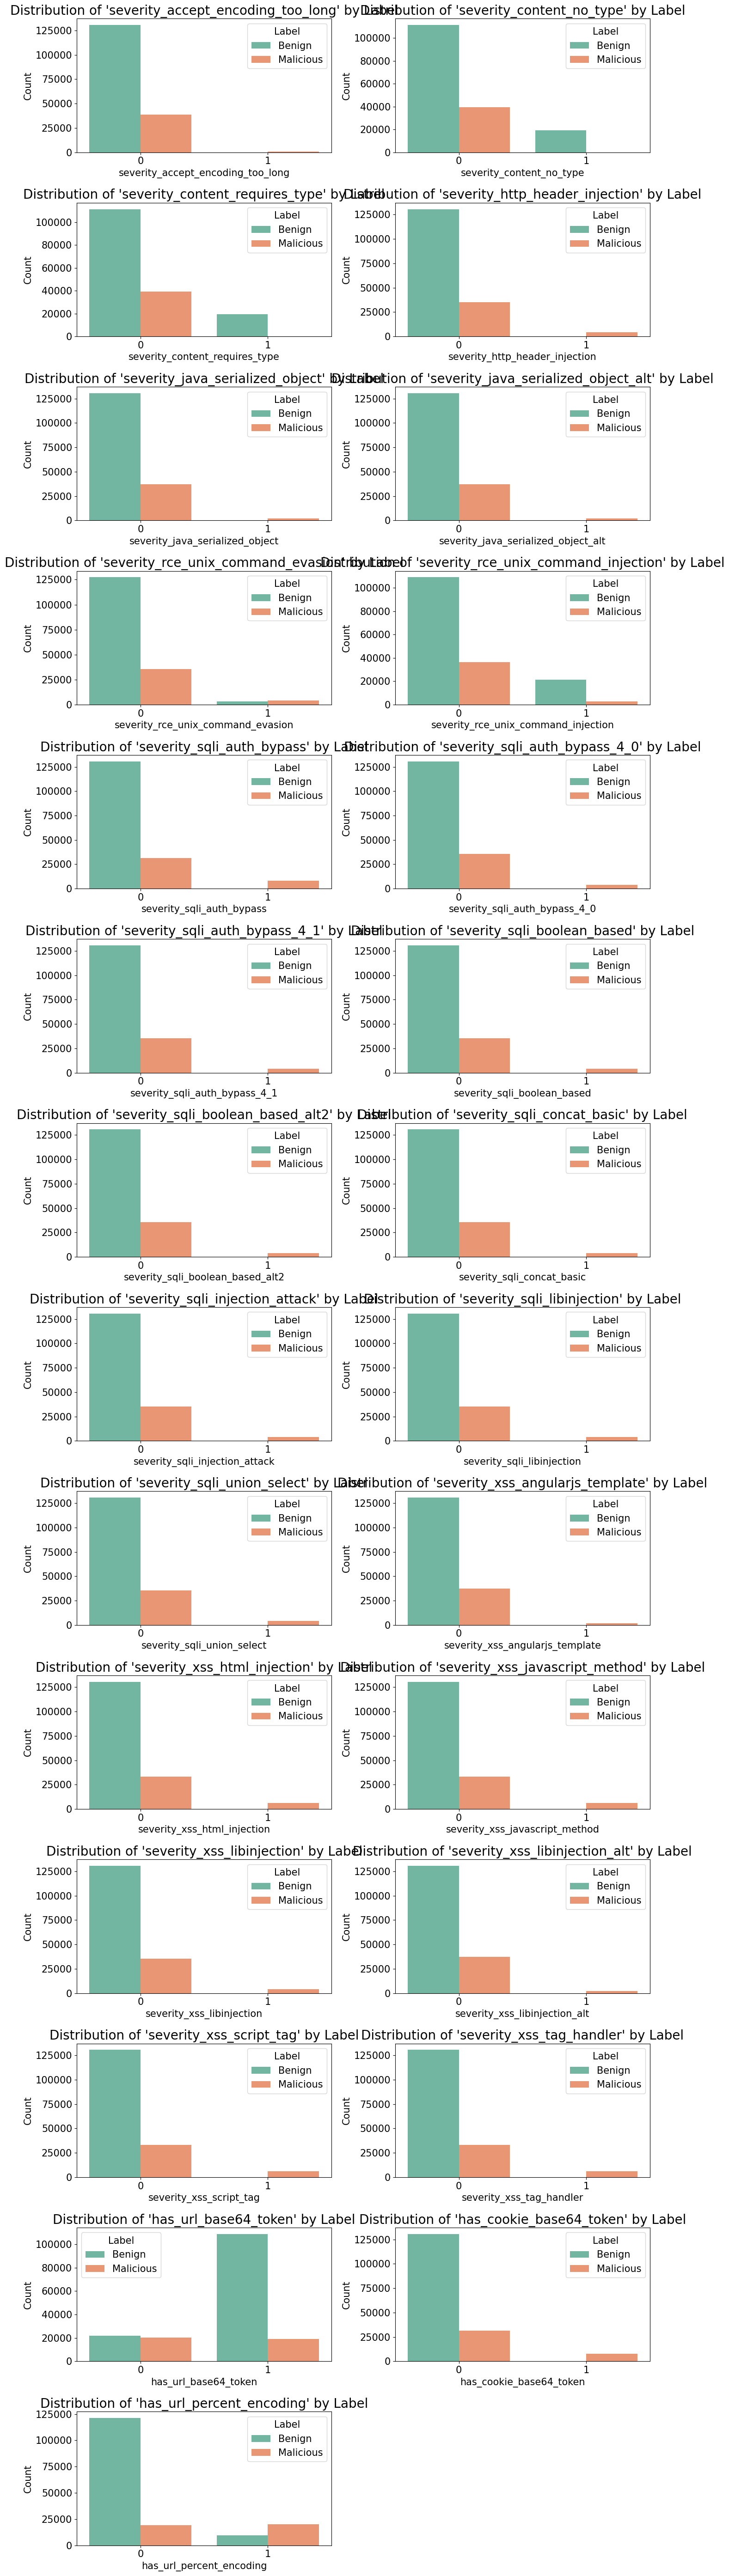

In [161]:
import math

# --- Identification of Binary Columns (excluding the label) ---

# Find columns that contain only binary values (0 or 1), except for the 'label' column
binary_cols = []
for col in data_vizcopy.columns:
    if col == 'label':
        continue
    try:
        unique_vals = pd.Series(data_vizcopy[col].dropna().unique()).dropna().unique()
        if set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
    except Exception:
        continue

print("Binary columns:", binary_cols)

# --- Plotting the Distribution of Each Binary Feature by Label ---

# Set up the subplot grid dimensions based on the number of binary features
n_cols = 2
n_rows = math.ceil(len(binary_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))

# Plot a countplot for each binary feature, split by the label (Benign vs Malicious)
for i, col in enumerate(binary_cols):
    ax = axes.flatten()[i]
    sns.countplot(
        data=data_vizcopy,
        x=col,
        hue='label',
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"Distribution of '{col}' by Label",fontsize=20)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend(title='Label', labels=['Benign', 'Malicious'])

# Remove any unused subplots if the grid is larger than needed
for j in range(len(binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


Binary columns: ['severity_accept_encoding_too_long', 'severity_content_no_type', 'severity_content_requires_type', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_java_serialized_object_alt', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_auth_bypass_4_0', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based', 'severity_sqli_boolean_based_alt2', 'severity_sqli_concat_basic', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_libinjection_alt', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_encoding']


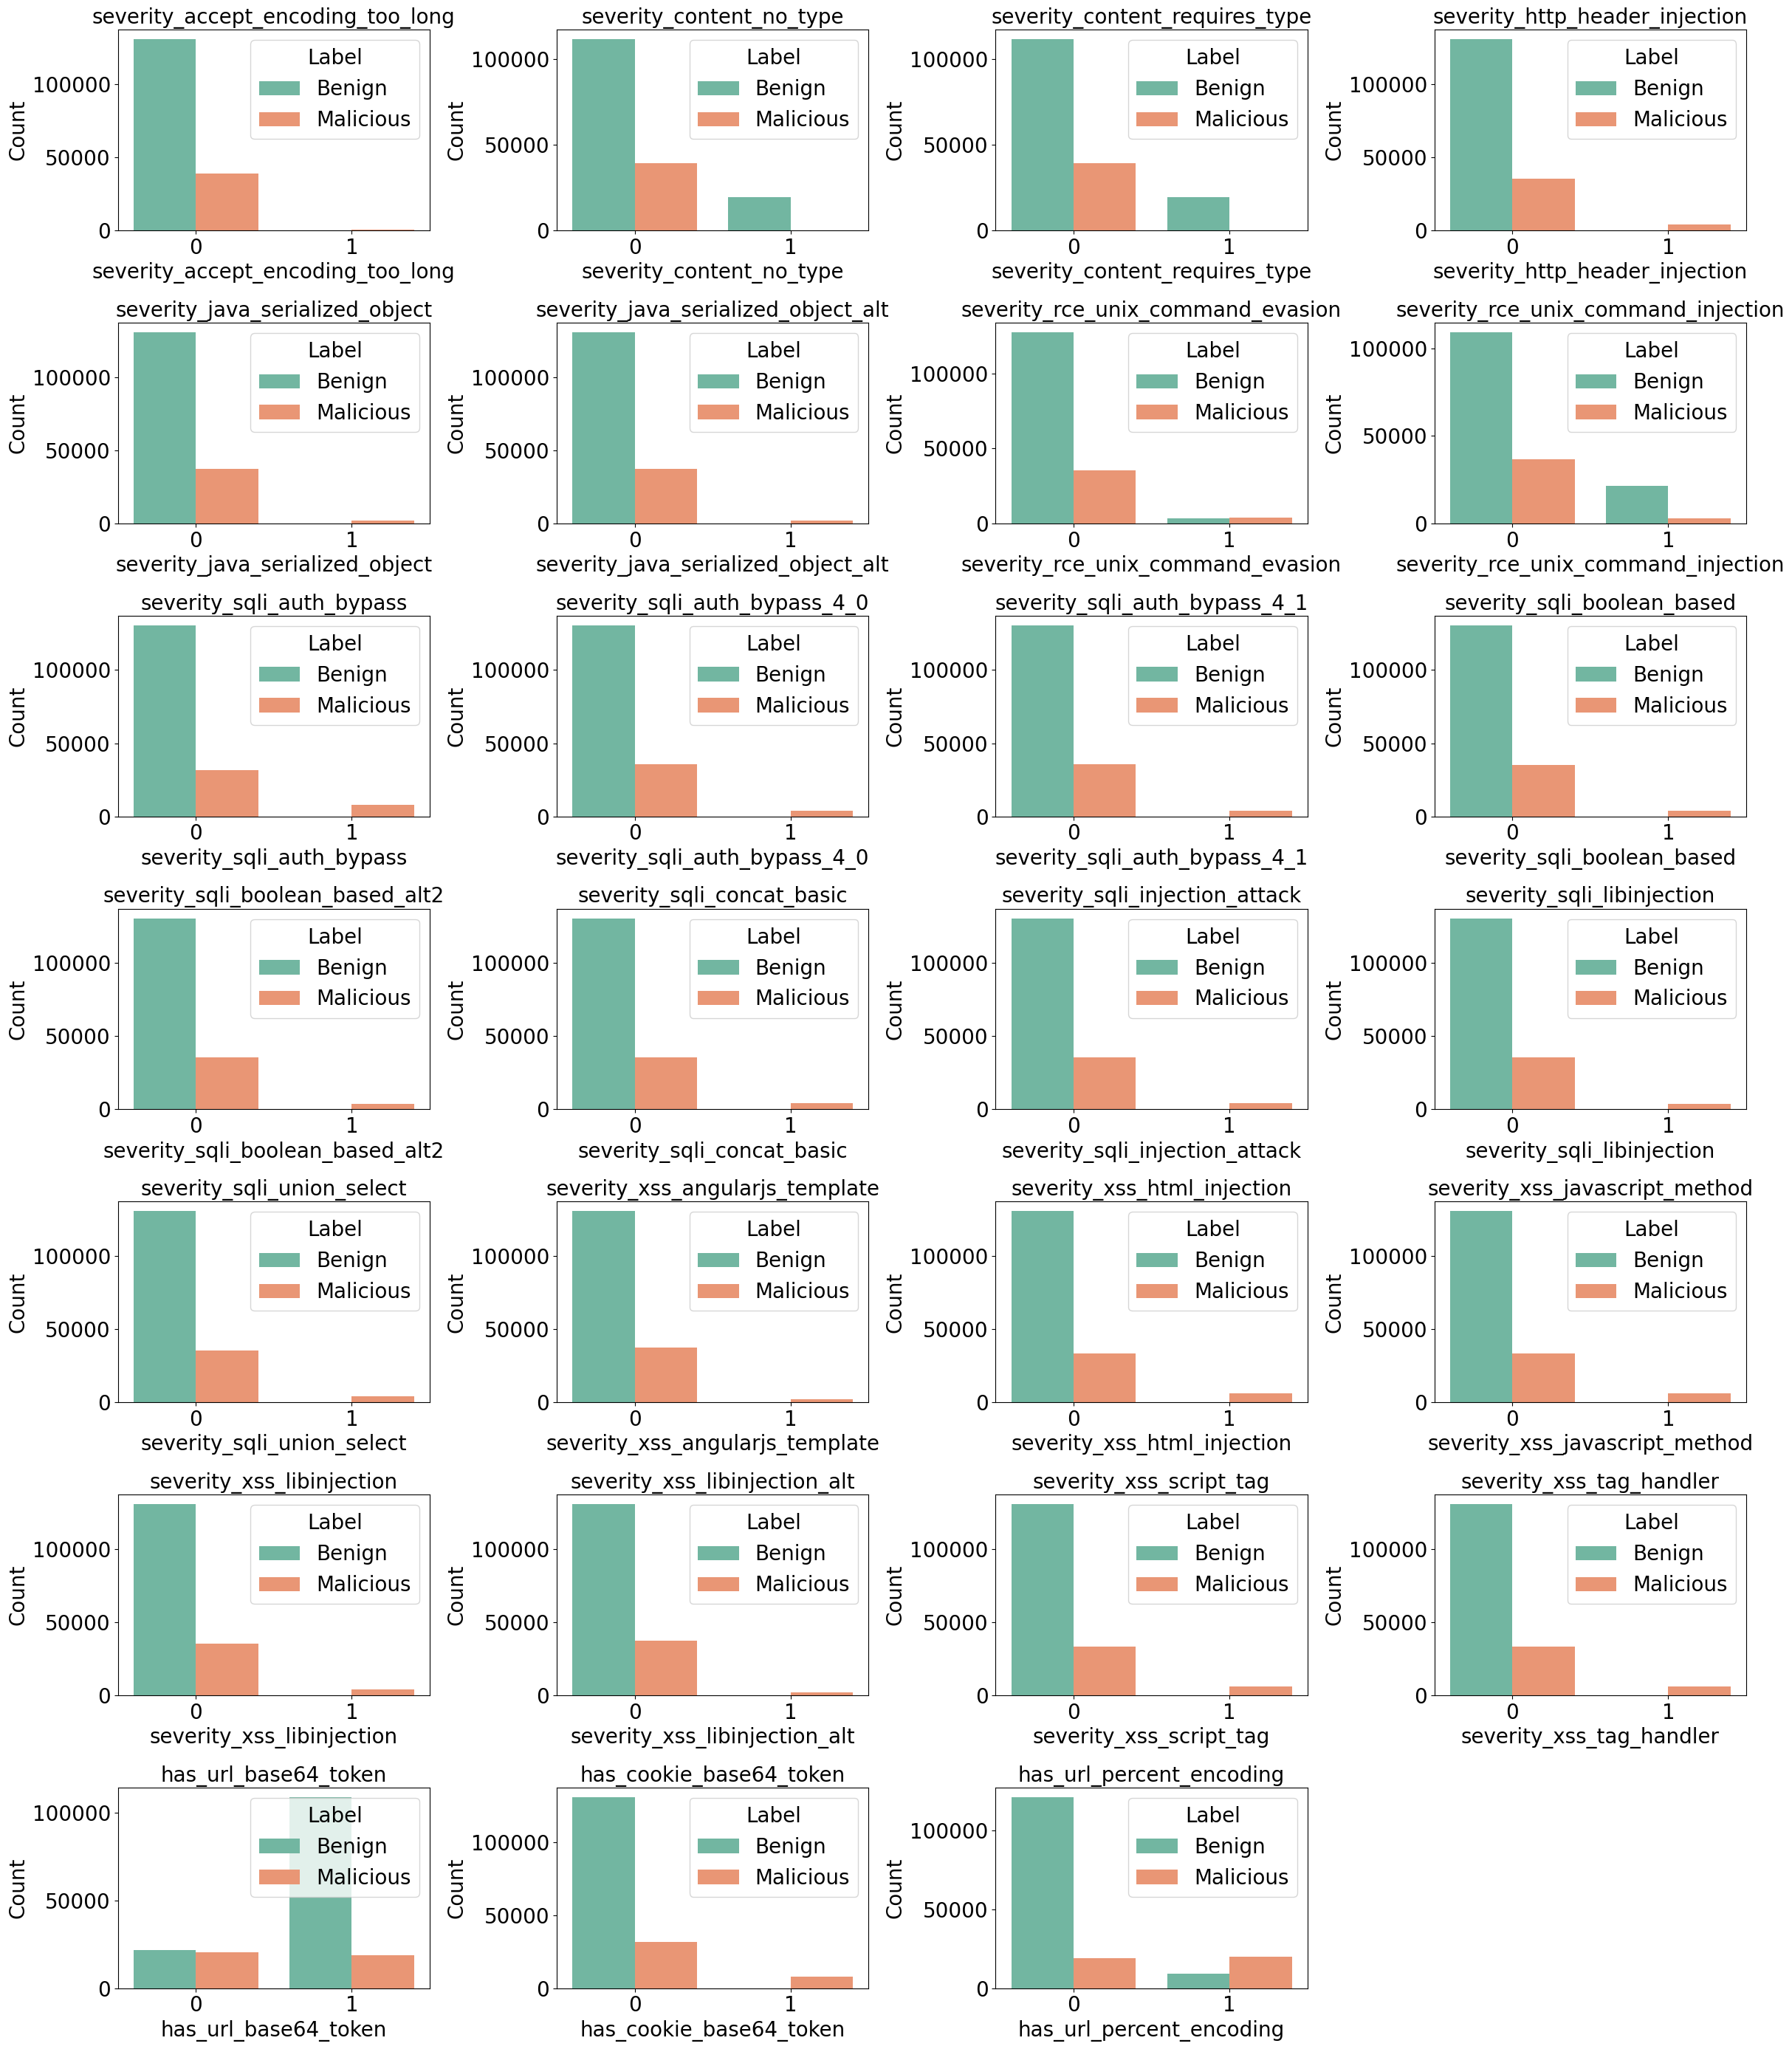

In [162]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Identification of Binary Columns (excluding the label) ---
binary_cols = []
for col in data_vizcopy.columns:
    if col == 'label':
        continue
    try:
        unique_vals = pd.Series(data_vizcopy[col].dropna().unique()).dropna().unique()
        if set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
    except Exception:
        continue

print("Binary columns:", binary_cols)

# --- Plotting the Distribution of Each Binary Feature by Label ---
n_cols = 4
n_rows = math.ceil(len(binary_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(binary_cols):
    ax = axes.flatten()[i]
    sns.countplot(
        data=data_vizcopy,
        x=col,
        hue='label',
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"{col}", fontsize=20)
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.legend(title='Label', labels=['Benign', 'Malicious'], fontsize=20, title_fontsize=20)
    ax.tick_params(axis='both', labelsize=20)

# Remove any unused subplots if grid is larger than needed
for j in range(len(binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [163]:
# --- Summary of the Discriminative Power of Binary Features ---

feature_summary = []

# Loop through all columns (excluding the label) to evaluate their discriminative utility
for col in data_vizcopy.columns:
    if col == 'label':
        continue
    try:
        # Only consider binary features
        values = data_vizcopy[col].dropna().unique()
        if not set(values).issubset({0, 1}):
            continue
    except Exception:
        continue

    # Calculate totals for each class
    benign_total = (data_vizcopy['label'] == 0).sum()
    malicious_total = (data_vizcopy['label'] == 1).sum()

    # Calculate the proportion of 1's in each class
    p_benign = data_vizcopy[(data_vizcopy[col] == 1) & (data_vizcopy['label'] == 0)].shape[0] / benign_total
    p_malicious = data_vizcopy[(data_vizcopy[col] == 1) & (data_vizcopy['label'] == 1)].shape[0] / malicious_total
    diff_ratio = abs(p_benign - p_malicious)

    # Classify feature utility based on the absolute difference between classes
    if diff_ratio >= 0.20:
        utility = "very_useful"
    elif diff_ratio >= 0.05:
        utility = "moderate"
    else:
        utility = "depends_context"

    feature_summary.append({
        'feature': col,
        'pct_benign': round(p_benign * 100, 2),
        'pct_malicious': round(p_malicious * 100, 2),
        'abs_diff': round(diff_ratio * 100, 2),
        'classification': utility
    })

# Create a summary DataFrame sorted by absolute difference
summary_df = pd.DataFrame(feature_summary).sort_values(by='abs_diff', ascending=False)

# Create an interactive table for summary_df
fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color='royalblue',
            align='center',
            font=dict(color='white', size=14)
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color='lavender',
            align='center',
            font=dict(size=13)
        )
    )]
)

fig.update_layout(
    title_text='Discriminative Power of Binary Features',
    margin=dict(l=0, r=0, t=40, b=0),
    height=min(600, 40 + 30 * len(summary_df))
)
fig.show()

In [164]:
# Print the summary table as plain text
print(summary_df)


                                feature  pct_benign  pct_malicious  abs_diff  \
26             has_url_percent_encoding        7.23          51.33     44.10   
24                 has_url_base64_token       83.29          48.15     35.13   
8             severity_sqli_auth_bypass        0.00          20.14     20.14   
25              has_cookie_base64_token        0.00          19.61     19.61   
18          severity_xss_html_injection        0.00          15.26     15.26   
22              severity_xss_script_tag        0.00          15.26     15.26   
19       severity_xss_javascript_method        0.00          15.26     15.26   
23             severity_xss_tag_handler        0.00          15.26     15.26   
2        severity_content_requires_type       14.77           0.00     14.77   
1              severity_content_no_type       14.77           0.00     14.77   
3        severity_http_header_injection        0.00          10.26     10.26   
13           severity_sqli_concat_basic 

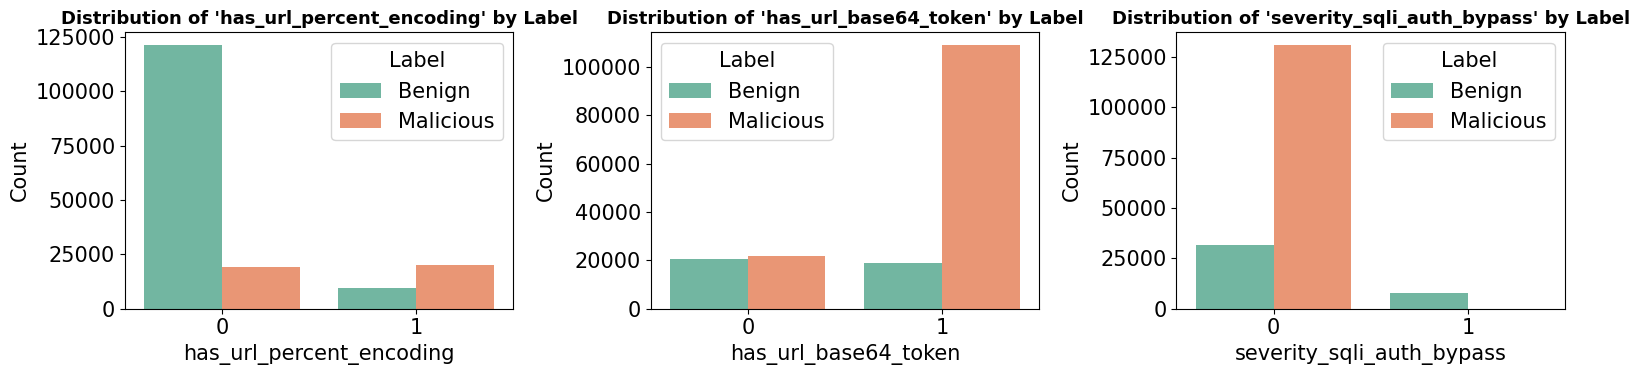

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    'has_url_percent_encoding',
    'has_url_base64_token',
    'severity_sqli_auth_bypass'
]

label_map = {0: "Benign", 1: "Malicious"}
data_vizcopy['label_name'] = data_vizcopy['label'].map(label_map)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, feat in enumerate(features_to_plot):
    sns.countplot(
        data=data_vizcopy,
        x=feat,
        hue='label_name',
        palette='Set2',
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of '{feat}' by Label", fontsize=13, weight='bold')
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Count")
    axes[i].legend(title='Label', labels=['Benign', 'Malicious'])
    # Clean x-axis for binary 0/1
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()


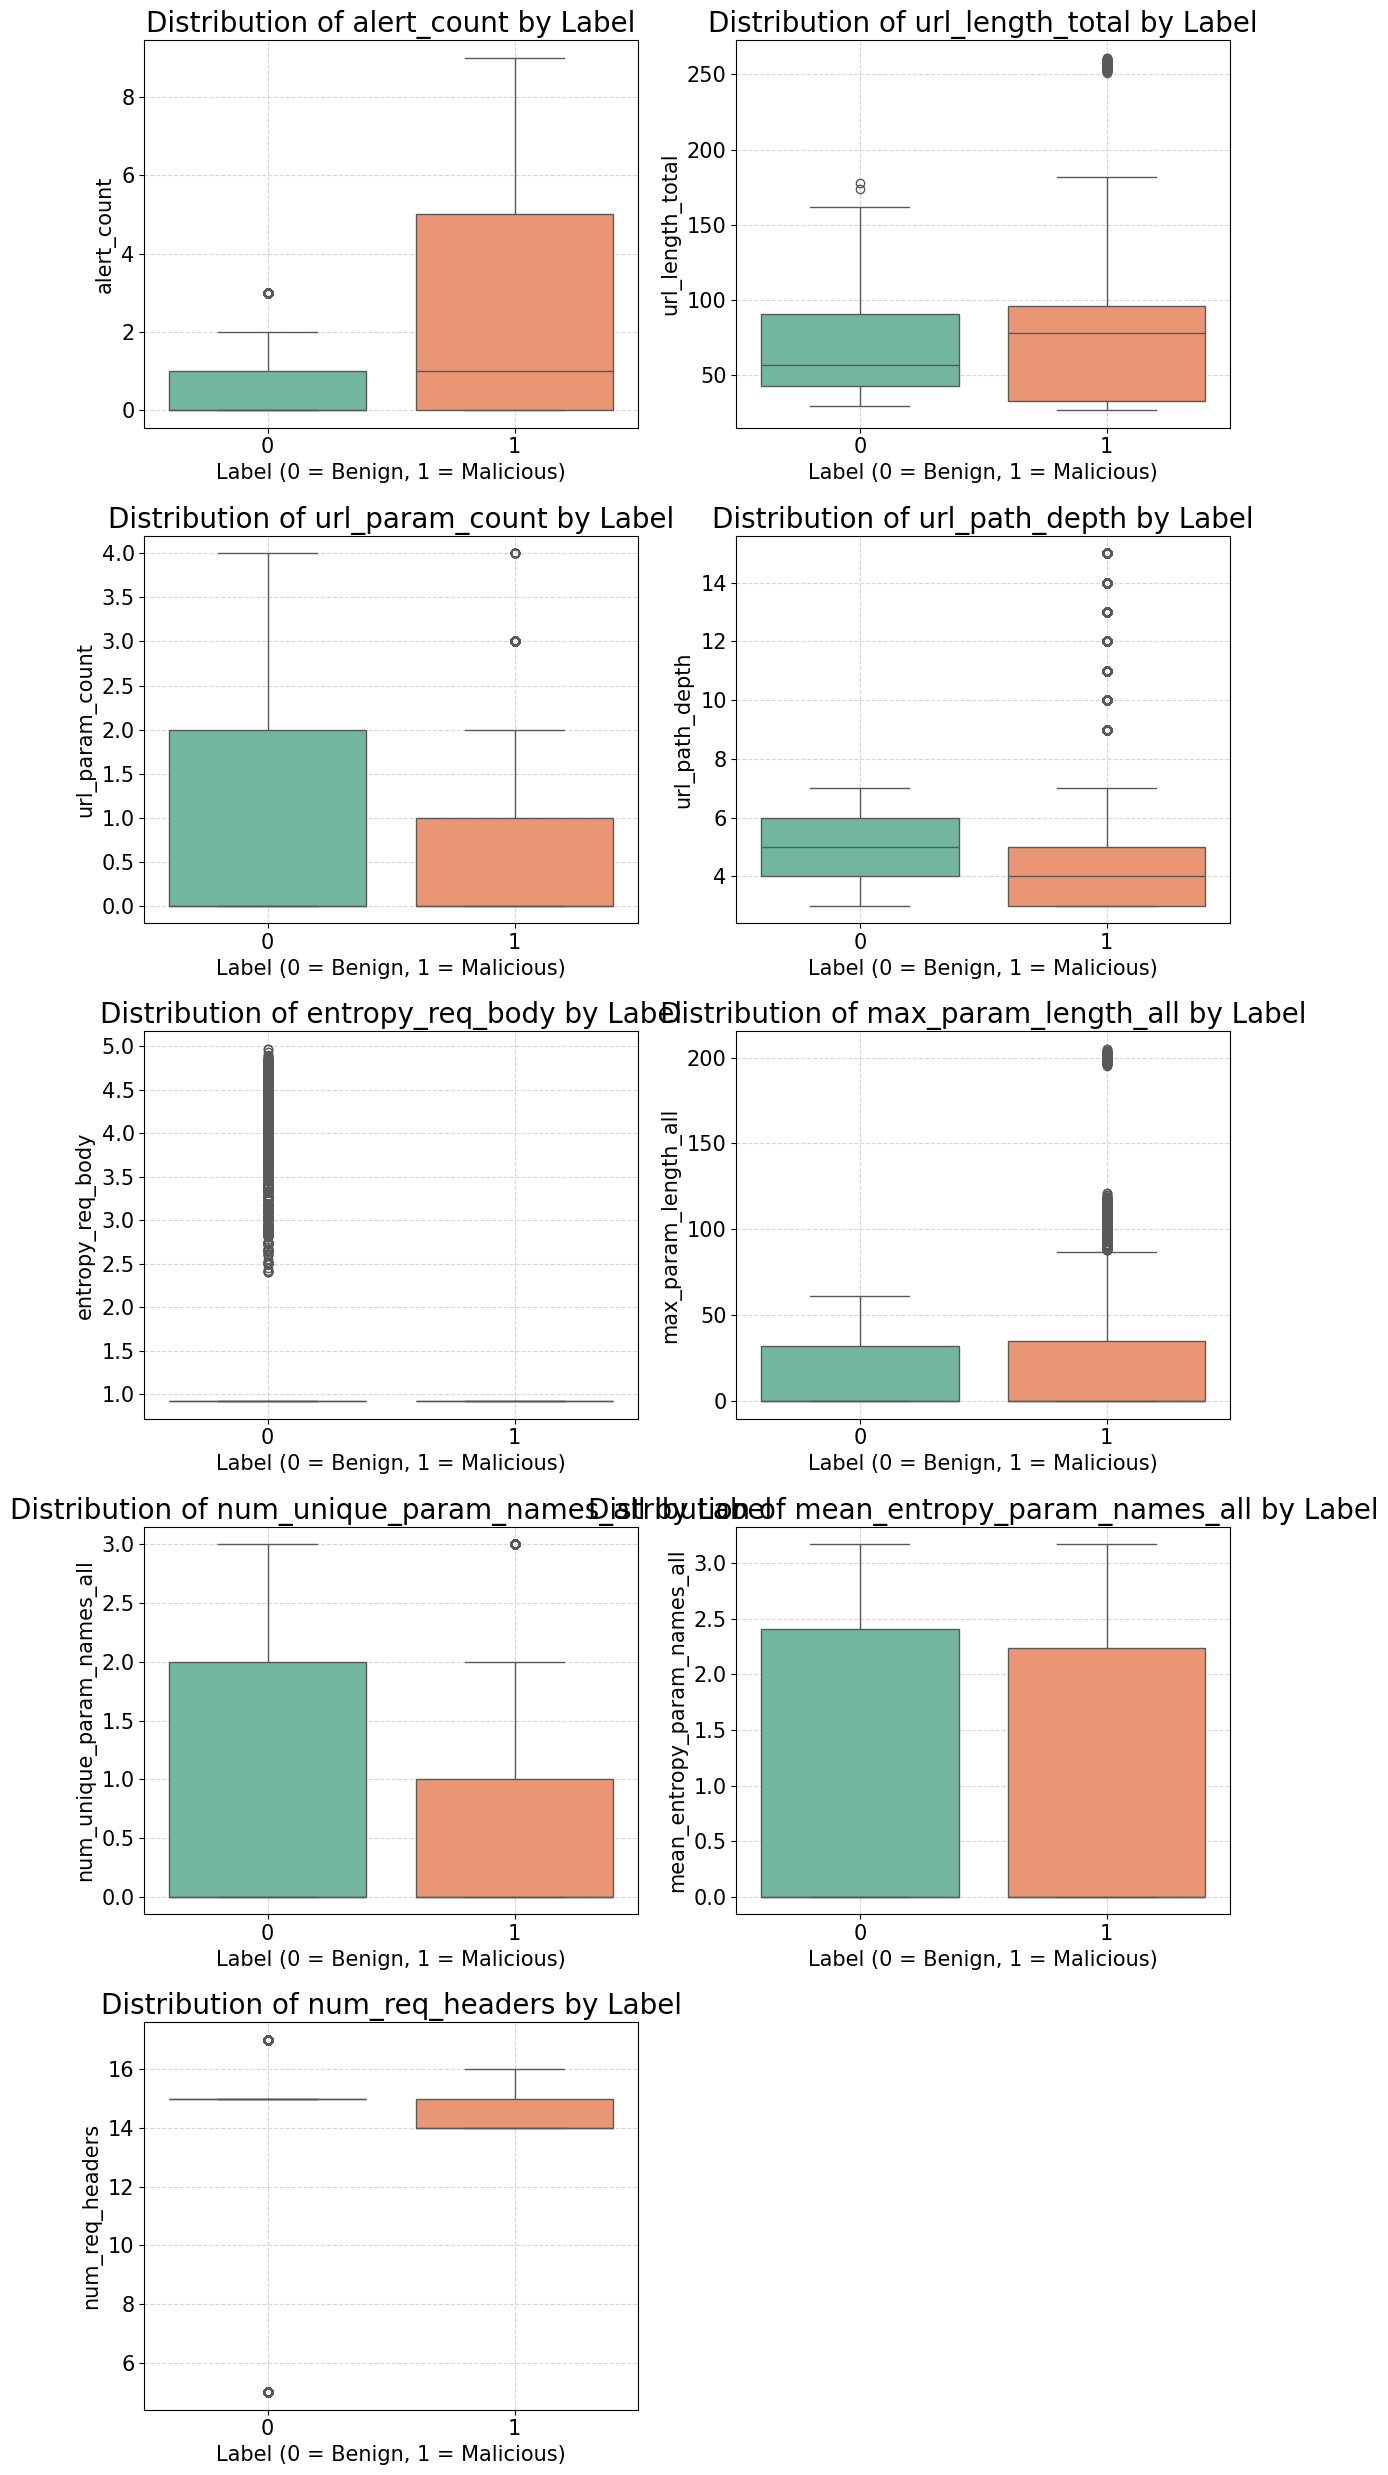

In [166]:
# --- Identification of Numeric, Non-Binary Columns ---

# Select numeric columns (excluding 'label') that have sufficient data points and are not binary
numeric_non_binary_cols = [
    col for col in data_vizcopy.select_dtypes(include=[np.number]).columns
    if col != 'label'
    and data_vizcopy[col].notna().sum() >= 10     # At least 10 non-null values
    and data_vizcopy[col].nunique() > 2         # More than 5 unique values (not binary)
]

# Set up a subplot grid based on the number of numeric features to visualize
n_cols = 2
n_rows = math.ceil(len(numeric_non_binary_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

# Plot a boxplot for each numeric feature, split by the label (Benign vs Malicious)
for i, col in enumerate(numeric_non_binary_cols):
    ax = axes.flatten()[i]
    sns.boxplot(
        data=data_vizcopy,
        x='label',
        y=col,
        hue='label',
        palette='Set2',
        ax=ax,
        legend=False
    )
    ax.set_title(f"Distribution of {col} by Label")
    ax.set_xlabel("Label (0 = Benign, 1 = Malicious)")
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', alpha=0.5)

# Remove any unused subplots if the grid is larger than the number of features
for j in range(len(numeric_non_binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

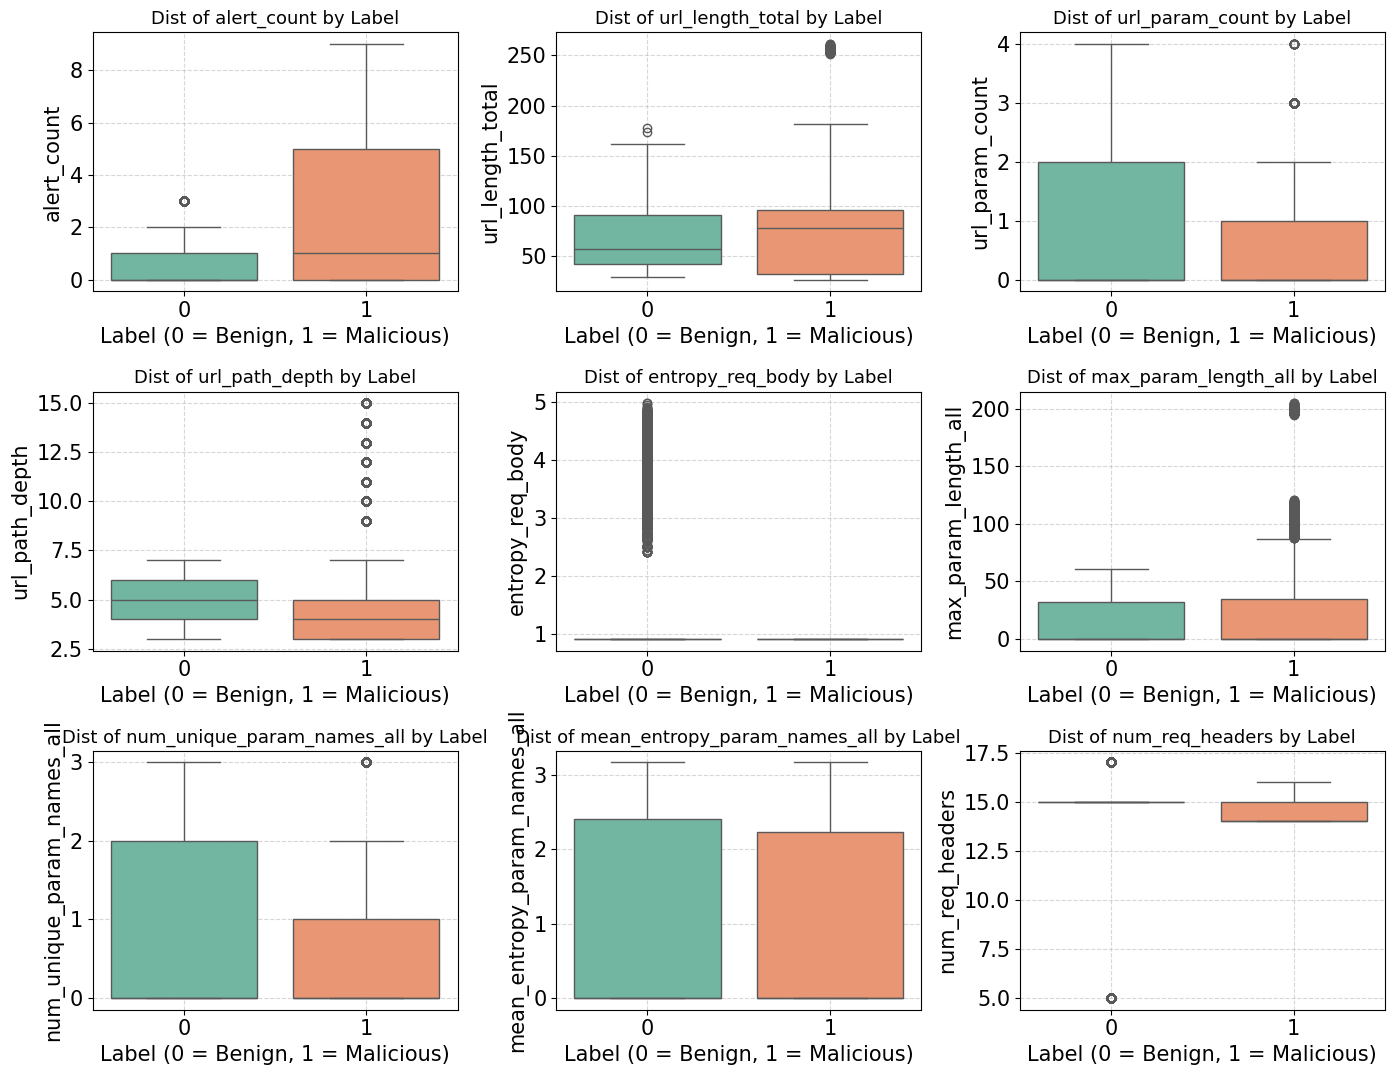

In [167]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Identification des colonnes numériques non binaires
numeric_non_binary_cols = [
    col for col in data_vizcopy.select_dtypes(include=[np.number]).columns
    if col != 'label'
    and data_vizcopy[col].notna().sum() >= 10
    and data_vizcopy[col].nunique() > 2
]

# Grille 3 x 3 (jusqu'à 9 features)
n_cols = 3
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 11))

# Afficher chaque feature
for i, col in enumerate(numeric_non_binary_cols[:9]):
    ax = axes.flatten()[i]
    sns.boxplot(
        data=data_vizcopy,
        x='label',
        y=col,
        hue='label',
        palette='Set2',
        ax=ax,
        legend=False
    )
    ax.set_title(f"Dist of {col} by Label", fontsize=13)
    ax.set_xlabel("Label (0 = Benign, 1 = Malicious)")
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', alpha=0.5)

# Supprimer les subplots non utilisés
for j in range(len(numeric_non_binary_cols[:9]), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [168]:
# Drop non pertinent feature (boxplot)
data_vizcopy.drop(columns=['entropy_req_body', 'mean_entropy_param_names_all'], inplace=True)

In [186]:
data_vizcopy.drop(columns=['label_name'], inplace=True)

In [169]:
from sklearn.preprocessing import LabelEncoder

# --- Convert to a Fully Numeric DataFrame (Label Included) ---

def drop_encode(df, extracted_headers=None, verbose=True):
    """
    Converts a DataFrame to a fully numeric representation:
    - Drops raw text/header columns already processed during feature extraction
    - Label-encodes remaining categorical/object columns
    - Converts boolean columns to integers
    - Skips columns containing lists
    """
    df_viz = df.copy()

    # Define columns to drop (typically raw HTTP/text fields already extracted as features)
    if extracted_headers is None:
        extracted_headers = [
            'url', 'req_body', 'req_Host', 'req_User-Agent',
            'req_Accept', 'req_Cookie', 'res_body', 'label_name'
        ]
    raw_to_drop = [col for col in extracted_headers if col in df_viz.columns]
    df_viz = df_viz.drop(columns=raw_to_drop)
    if verbose and raw_to_drop:
        print(f"Dropped already extracted headers: {raw_to_drop}")

    # Encode all remaining non-numeric columns (excluding columns containing lists)
    non_numeric_cols = df_viz.select_dtypes(include=['object', 'category']).columns
    for col in non_numeric_cols:
        if df_viz[col].apply(lambda x: isinstance(x, list)).any():
            if verbose:
                print(f"Skipping encoding for column '{col}' (contains lists).")
            df_viz = df_viz.drop(columns=[col])
            continue
        df_viz[col] = df_viz[col].astype('category').cat.codes

    # Convert all boolean columns to integers
    bool_cols = df_viz.select_dtypes(include=['bool']).columns
    df_viz[bool_cols] = df_viz[bool_cols].astype(int)

    return df_viz

# Apply the function to obtain a fully numeric DataFrame suitable for machine learning
df_encoded = drop_encode(data_vizcopy)

# Print a summary of the resulting DataFrame
print(df_encoded.info())

Dropped already extracted headers: ['label_name']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169955 entries, 0 to 169954
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   Attack_Tag                           169955 non-null  int8 
 1   severity_accept_encoding_too_long    169955 non-null  int64
 2   severity_content_no_type             169955 non-null  int64
 3   severity_content_requires_type       169955 non-null  int64
 4   severity_http_header_injection       169955 non-null  int64
 5   severity_java_serialized_object      169955 non-null  int64
 6   severity_java_serialized_object_alt  169955 non-null  int64
 7   severity_rce_unix_command_evasion    169955 non-null  int64
 8   severity_rce_unix_command_injection  169955 non-null  int64
 9   severity_sqli_auth_bypass            169955 non-null  int64
 10  severity_sqli_auth_bypass_4_0        169955 non-null  

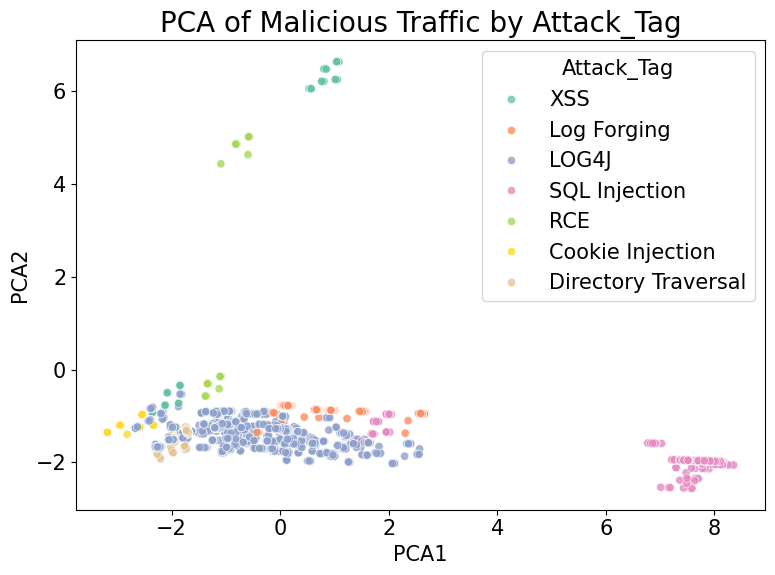

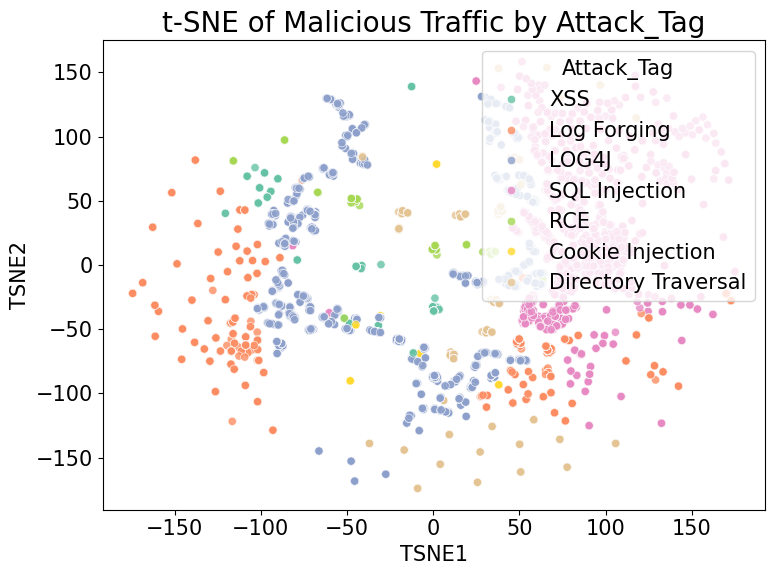

In [170]:
# --- PCA and t-SNE Visualization of Malicious Traffic by Attack Tag ---

# Isolate malicious samples (label == 1) for dimensionality reduction analysis
malicious_df = data_vizcopy[data_vizcopy['label'] == 1].copy()
X_malicious = malicious_df.drop(columns=['label']).copy()

# Encode any remaining object (categorical) columns using LabelEncoder
for col in X_malicious.select_dtypes(include='object').columns:
    X_malicious[col] = X_malicious[col].astype(str).replace('nan', pd.NA)
    X_malicious[col] = LabelEncoder().fit_transform(X_malicious[col].astype(str))

# Impute missing values if necessary, using the mean of each column
if X_malicious.isnull().sum().sum() > 0:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_malicious_imputed = imputer.fit_transform(X_malicious)
else:
    X_malicious_imputed = X_malicious.values

# Standardize all features for fair comparison in PCA and t-SNE
X_scaled = StandardScaler().fit_transform(X_malicious_imputed)

# Perform Principal Component Analysis (PCA) to reduce to 2 components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Attack_Tag'] = malicious_df['Attack_Tag'].reset_index(drop=True)

# Perform t-SNE to reduce to 2 components (nonlinear dimensionality reduction)
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Attack_Tag'] = malicious_df['Attack_Tag'].reset_index(drop=True)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Attack_Tag', palette='Set2', alpha=0.8)
plt.title("PCA of Malicious Traffic by Attack_Tag")
plt.tight_layout()
plt.show()

# Visualize the t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Attack_Tag', palette='Set2', alpha=0.8)
plt.title("t-SNE of Malicious Traffic by Attack_Tag")
plt.tight_layout()
plt.show()


In [171]:
# --- Intra-Attack Diversity Calculation ---

intra_attack_diversity = {}
for tag in malicious_df['Attack_Tag'].unique():
    # Select all samples of the current attack type
    subset_scaled = X_scaled[malicious_df['Attack_Tag'].reset_index(drop=True) == tag]
    if len(subset_scaled) > 1:
        dist_matrix = pairwise_distances(subset_scaled)
        upper_tri_indices = np.triu_indices_from(dist_matrix, k=1)
        mean_dist = np.mean(dist_matrix[upper_tri_indices]) if upper_tri_indices[0].size > 0 else 0
    else:
        mean_dist = 0
    intra_attack_diversity[tag] = mean_dist

# Count the number of samples per attack type
attack_distribution = malicious_df['Attack_Tag'].value_counts()

# Build a summary DataFrame: mean intra-cluster distance and sample count per attack type
summary_df = pd.DataFrame.from_dict(intra_attack_diversity, orient='index', columns=['Mean Intra-Class Distance'])
summary_df['Sample Count'] = attack_distribution
summary_df.index.name = 'Attack_Tag'
summary_df = summary_df.sort_values(by='Sample Count', ascending=False).reset_index()

# --- Interactive Table Display with Plotly ---
fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color='royalblue',
            align='center',
            font=dict(color='white', size=15)
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color='lavender',
            align='center',
            font=dict(size=14)
        )
    )]
)

fig.update_layout(
    title_text='Intra-Attack Diversity Summary',
    margin=dict(l=0, r=0, t=40, b=0),
    height=min(600, 60 + 32 * len(summary_df))
)
fig.show()

In [172]:
# --- Correlation Analysis with the Label ---

# Select features to include in the correlation analysis (excluding primary_key if present)
features = [col for col in df_encoded.columns if col != 'primary_key']

# Compute the correlation matrix for all features, focusing on correlation with 'label'
corr_matrix = df_encoded[features].corr()
label_corr = corr_matrix['label'].sort_values(ascending=False)
corr_df = label_corr.reset_index()
corr_df.columns = ['Feature', 'Correlation with Label']

# --- Display as a Beautiful Interactive Table (Plotly) ---
fig = go.Figure(
    data=[go.Table(
        header=dict(
            values= corr_df.columns,
            fill_color='royalblue',
            align='center',
            font=dict(color='white', size=15)
        ),
        cells=dict(
            values=[corr_df[col] for col in corr_df.columns],
            fill_color='lavender',
            align='center',
            font=dict(size=14)
        )
    )]
)

fig.update_layout(
    title_text='Feature Correlation with Label',
    margin=dict(l=0, r=0, t=40, b=0),
    height=min(900, 60 + 32 * len(corr_df))
)
fig.show()

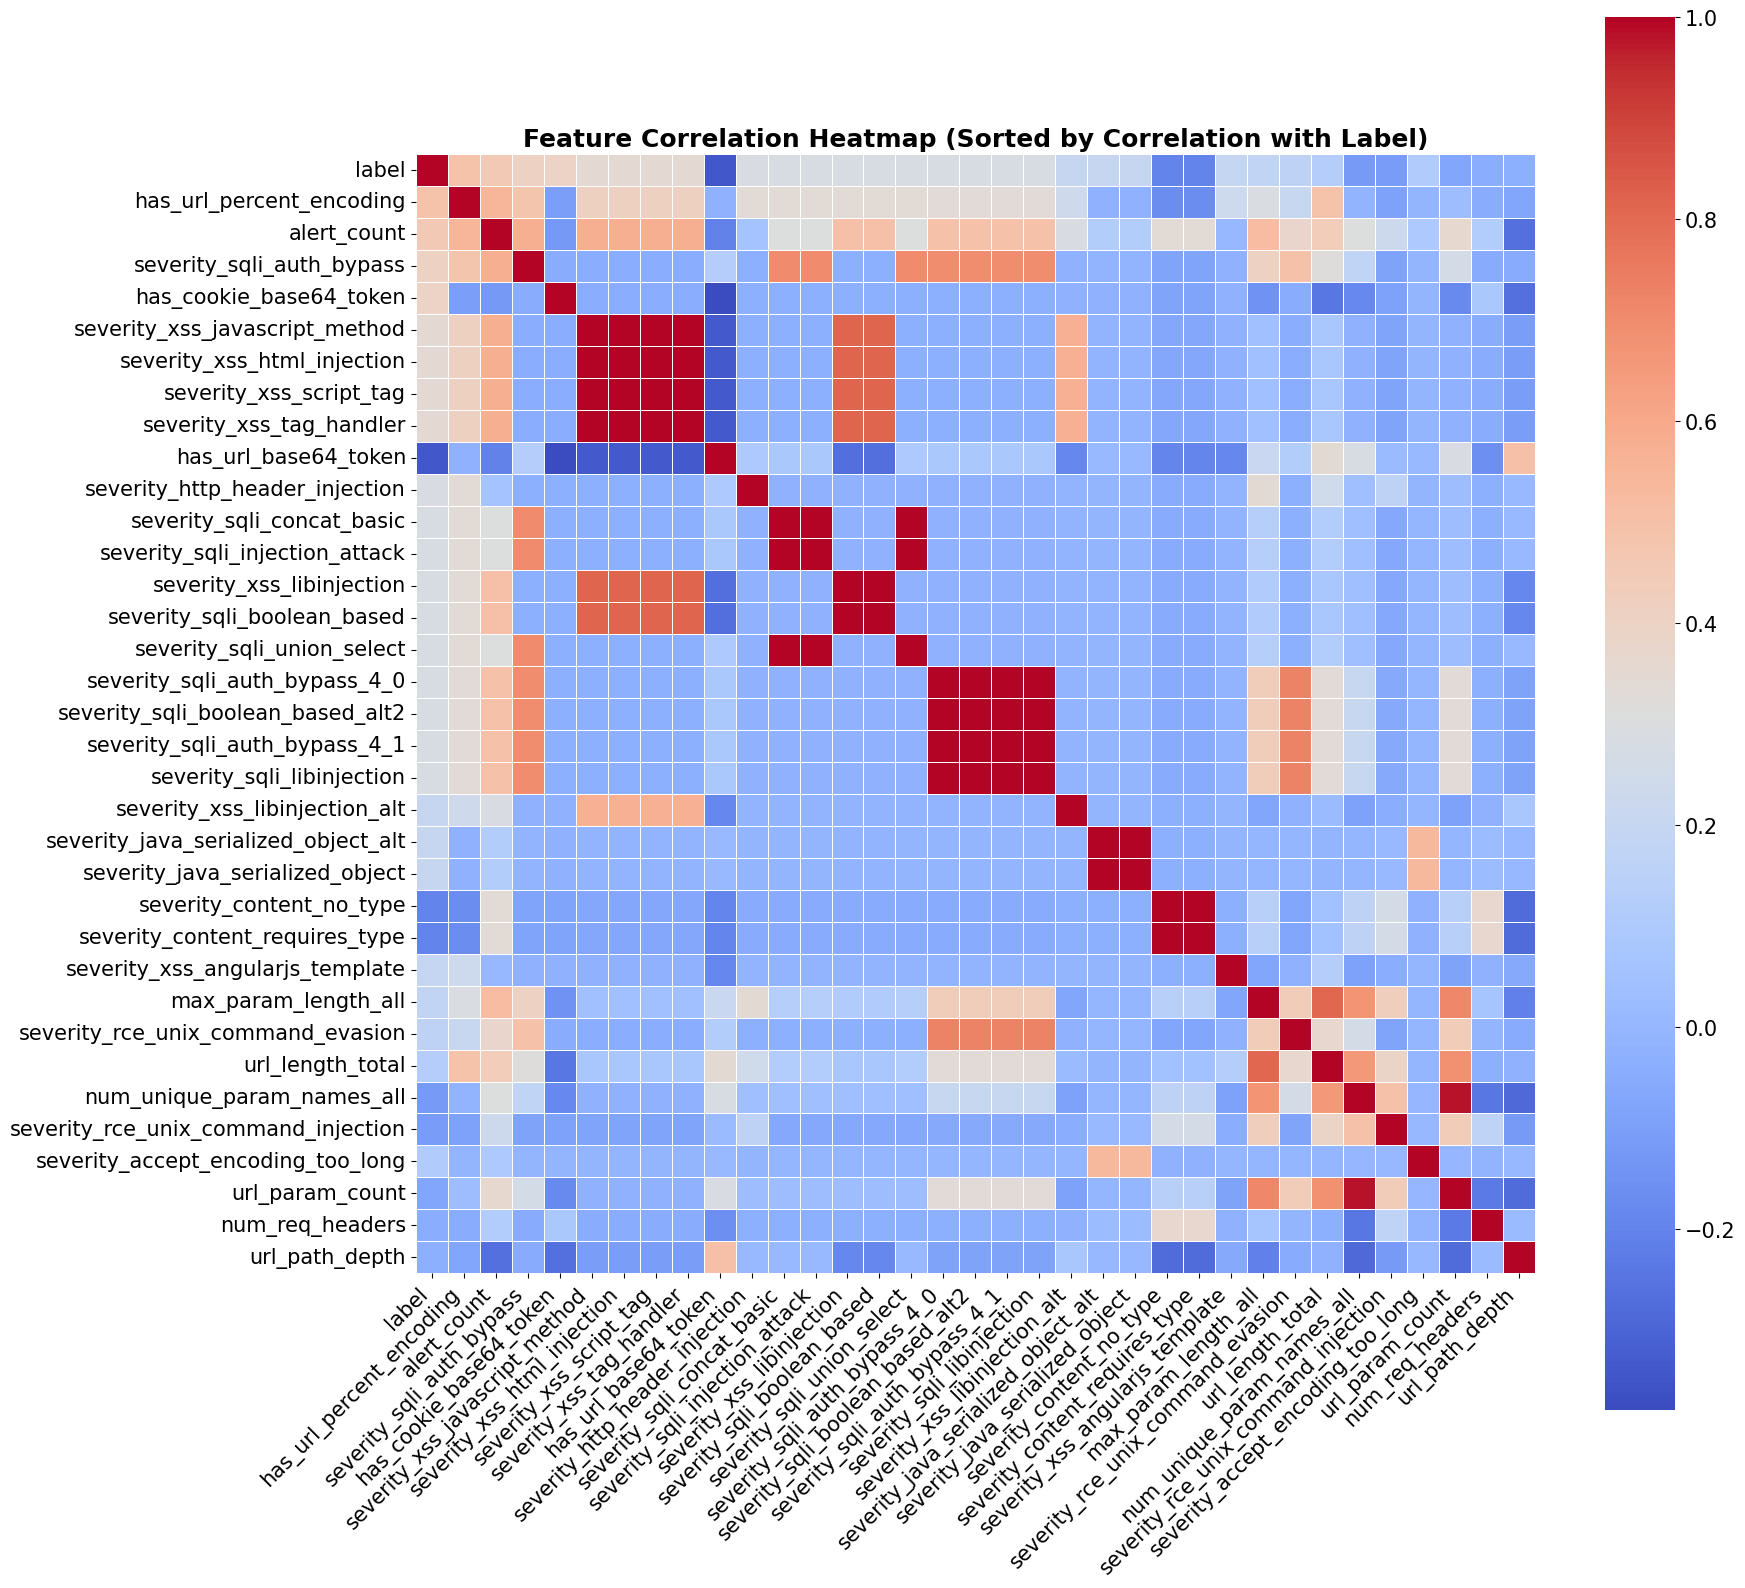

In [173]:
# --- Sorted Feature Correlation Heatmap (by correlation with the label) ---

# Compute correlation matrix for all numeric features (including the label)
numeric_features = data_vizcopy.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()

# Sort features by absolute correlation with the label (highest first)
abs_label_corr = corr_matrix['label'].abs().sort_values(ascending=False)
sorted_features = abs_label_corr.index.tolist()

# Reorder the correlation matrix
sorted_corr_matrix = corr_matrix.loc[sorted_features, sorted_features]

# Create the heatmap
plt.figure(figsize=(min(1 + len(sorted_features)*0.5, 22), min(1 + len(sorted_features)*0.5, 22)))
sns.heatmap(
    sorted_corr_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.85}
)

plt.title("Feature Correlation Heatmap (Sorted by Correlation with Label)", fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [187]:
# --- Save the Preprocessed Feature DataFrame to CSV ---

# Define the output path for the preprocessed and feature-engineered DataFrame
OUTPUT_PATH = '/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_binary.csv'

# Save the DataFrame to CSV format, without the index
data_vizcopy.to_csv(OUTPUT_PATH, index=False)
print(f"Final cleaned DataFrame saved: {OUTPUT_PATH}")

# Display a summary of the DataFrame (column types, non-null counts, memory usage)
data_vizcopy.info()

Final cleaned DataFrame saved: /content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_binary.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169955 entries, 0 to 169954
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Attack_Tag                           39336 non-null   object
 1   severity_accept_encoding_too_long    169955 non-null  int64 
 2   severity_content_no_type             169955 non-null  int64 
 3   severity_content_requires_type       169955 non-null  int64 
 4   severity_http_header_injection       169955 non-null  int64 
 5   severity_java_serialized_object      169955 non-null  int64 
 6   severity_java_serialized_object_alt  169955 non-null  int64 
 7   severity_rce_unix_command_evasion    169955 non-null  int64 
 8   severity_rce_unix_command_injection  169955 non-null  int64 
 9   severity_sql

In [175]:
# Créer une copie propre
data_vizcopy2.drop(columns=['label'], inplace=True)
data_vizcopy2 = data_vizcopy2[data_vizcopy2['Attack_Tag'].notna()].reset_index(drop=True)


Binary columns: ['severity_accept_encoding_too_long', 'severity_content_no_type', 'severity_content_requires_type', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_java_serialized_object_alt', 'severity_rce_unix_command_evasion', 'severity_rce_unix_command_injection', 'severity_sqli_auth_bypass', 'severity_sqli_auth_bypass_4_0', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based', 'severity_sqli_boolean_based_alt2', 'severity_sqli_concat_basic', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_angularjs_template', 'severity_xss_html_injection', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_libinjection_alt', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_encoding']


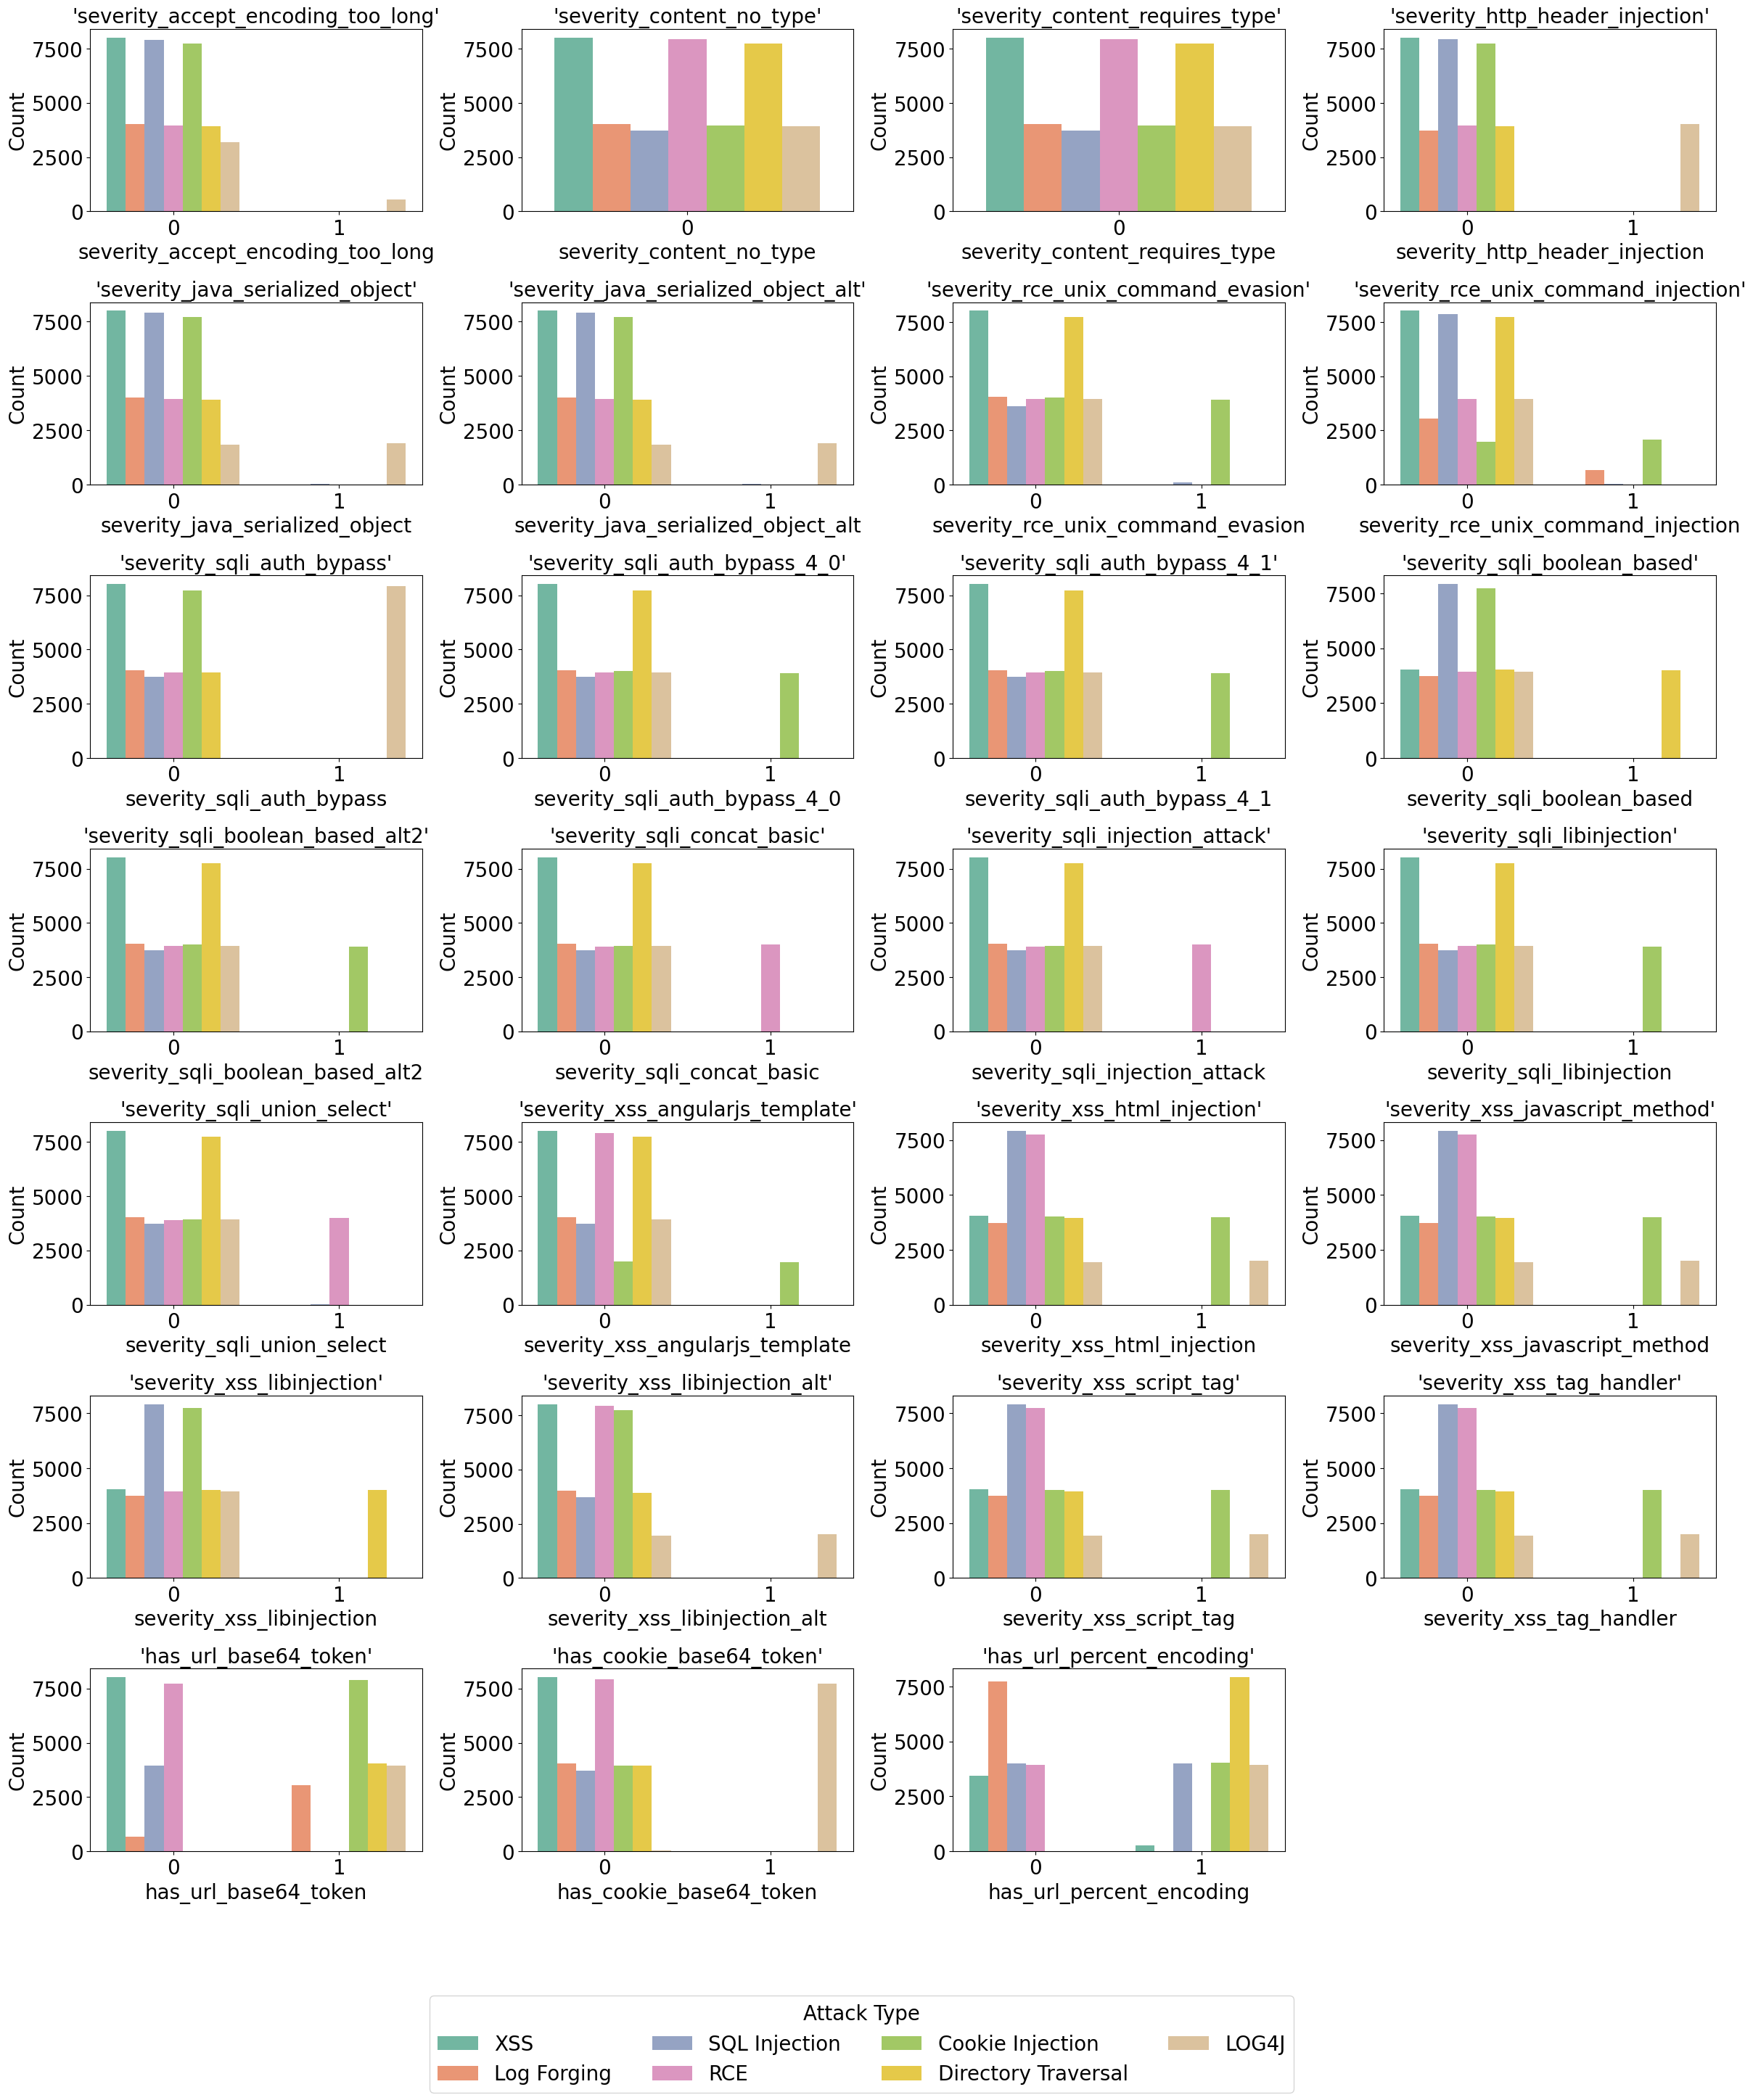

In [176]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Identification of Binary Columns (excluding the target) ---
binary_cols = []
for col in data_vizcopy2.columns:
    if col == 'Attack_Tag':
        continue
    try:
        unique_vals = pd.Series(data_vizcopy2[col].dropna().unique())
        if set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
    except Exception:
        continue

print("Binary columns:", binary_cols)

# --- Plotting the Distribution of Each Binary Feature by Attack Type ---
n_cols = 4
n_rows = math.ceil(len(binary_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

legend_handles = None
legend_labels = None

for i, col in enumerate(binary_cols):
    ax = axes.flatten()[i]
    g = sns.countplot(
        data=data_vizcopy2,
        x=col,
        hue='Attack_Tag',
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"'{col}'", fontsize=20)
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    # Stocke les handles et labels du premier subplot avec légende
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    # Supprime la légende de chaque axe
    ax.get_legend().remove()

# Place une légende globale (en bas ou à droite selon préférence)
fig.legend(
    legend_handles, legend_labels,
    title='Attack Type', title_fontsize=20, fontsize=20,
    loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.04)
)

# Retire les axes vides si besoin
for j in range(len(binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Ajuste pour laisser place à la légende
plt.show()


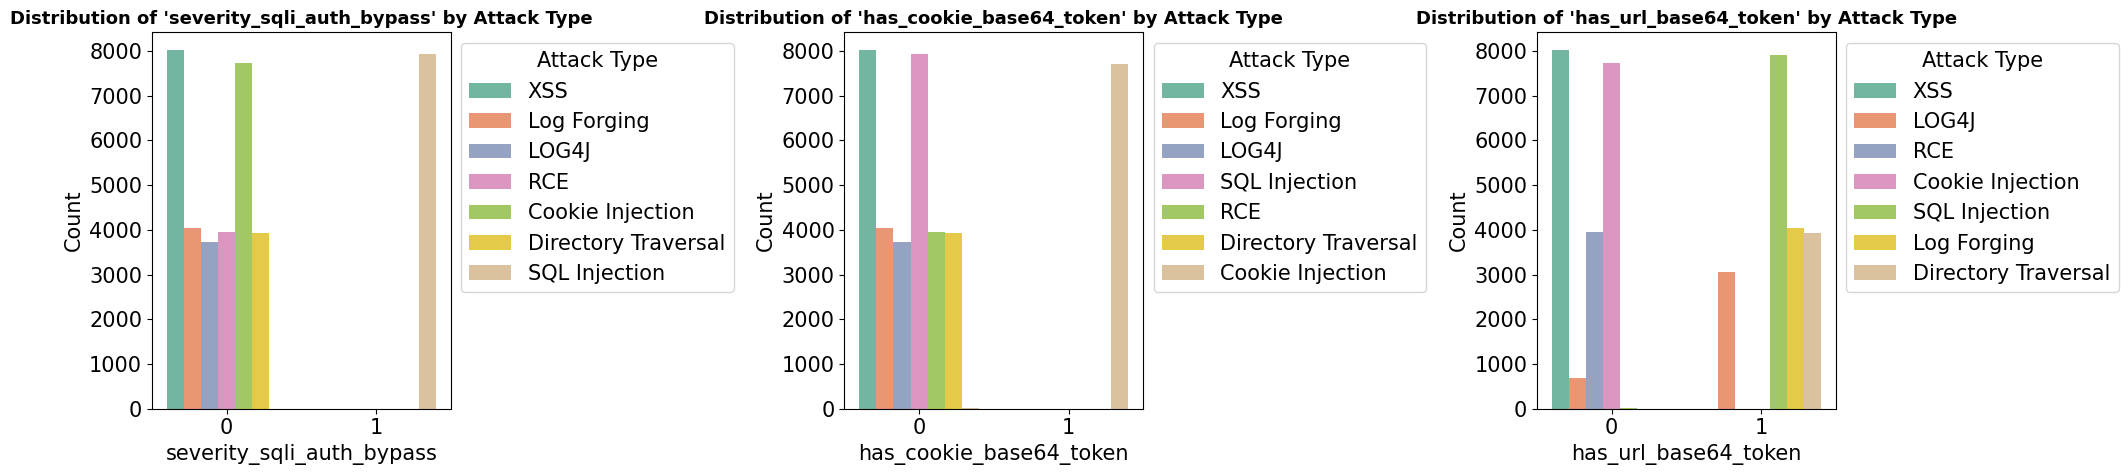

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = [
    'severity_sqli_auth_bypass',
    'has_cookie_base64_token',
    'has_url_base64_token'
]

n_cols = 3
n_rows = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5))

for i, col in enumerate(features_to_plot):
    ax = axes[i]
    sns.countplot(
        data=data_vizcopy2,
        x=col,
        hue='Attack_Tag',
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"Distribution of '{col}' by Attack Type", fontsize=13, weight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.legend(title='Attack Type', bbox_to_anchor=(1, 1))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()


In [178]:
data_vizcopy2.drop(columns=['severity_content_requires_type','severity_content_no_type'], inplace=True)

In [179]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

feature_summary = []
attack_tags = data_vizcopy2['Attack_Tag'].unique().tolist()  # plus besoin de dropna car plus de Benign

for col in data_vizcopy2.columns:
    if col == 'Attack_Tag':
        continue
    try:
        values = data_vizcopy2[col].dropna().unique()
        if not set(values).issubset({0, 1}):
            continue
    except Exception:
        continue

    tag_props = {}
    # Proportion de 1 par classe d'attaque
    for tag in attack_tags:
        tag_total = (data_vizcopy2['Attack_Tag'] == tag).sum()
        tag_props[tag] = (
            data_vizcopy2[(data_vizcopy2[col] == 1) & (data_vizcopy2['Attack_Tag'] == tag)].shape[0] / tag_total
            if tag_total > 0 else np.nan
        )

    # Calcul du score discriminant : pour chaque classe, différence absolue avec la moyenne des autres
    discrim_scores = []
    for cls in attack_tags:
        others = [tag_props[t] for t in attack_tags if t != cls and not np.isnan(tag_props[t])]
        if not np.isnan(tag_props[cls]) and others:
            mean_others = np.mean(others)
            discrim_scores.append(abs(tag_props[cls] - mean_others))
    max_discrim = max(discrim_scores) if discrim_scores else np.nan

    # Classification adaptée
    if max_discrim >= 0.20:
        utility = "very_useful"
    elif max_discrim >= 0.05:
        utility = "moderate"
    else:
        utility = "depends_context"

    feature_summary.append(
        dict(
            feature=col,
            **{f"pct_{tag}": round(100 * tag_props[tag], 2) for tag in tag_props},
            discrim_score=round(max_discrim * 100, 2) if not np.isnan(max_discrim) else None,
            classification=utility
        )
    )

summary_df = pd.DataFrame(feature_summary).sort_values(by='discrim_score', ascending=False)

# Table Plot
fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=list(summary_df.columns),
            fill_color='royalblue',
            align='center',
            font=dict(color='white', size=14)
        ),
        cells=dict(
            values=[summary_df[col] for col in summary_df.columns],
            fill_color='lavender',
            align='center',
            font=dict(size=13)
        )
    )]
)

fig.update_layout(
    title_text='Discriminative Power of Binary Features by Attack Type (Delta vs. Mean Others)',
    margin=dict(l=0, r=0, t=40, b=0),
    height=min(600, 40 + 30 * len(summary_df))
)
fig.show()


In [180]:
# Print the summary table as plain text
print(summary_df)

                                feature  pct_XSS  pct_Log Forging  pct_LOG4J  \
1        severity_http_header_injection     0.00           100.00       0.00   
6             severity_sqli_auth_bypass     0.00             0.00       0.00   
23              has_cookie_base64_token     0.00             0.00       0.00   
22                 has_url_base64_token     0.00           100.00      81.78   
24             has_url_percent_encoding    49.91           100.00       7.61   
19        severity_xss_libinjection_alt     0.00             0.00       0.00   
12       severity_sqli_injection_attack     0.00             0.00       0.00   
11           severity_sqli_concat_basic     0.00             0.00       0.00   
14           severity_sqli_union_select     0.00             0.00       0.05   
3   severity_java_serialized_object_alt     0.27             0.32      50.66   
2       severity_java_serialized_object     0.27             0.32      50.66   
18            severity_xss_libinjection 

Numeric, non-binary columns: ['alert_count', 'url_length_total', 'url_path_depth', 'max_param_length_all', 'mean_entropy_param_names_all']


<ipython-input-181-0591df75a7d6>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-181-0591df75a7d6>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-181-0591df75a7d6>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-181-0591df75a7d6>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-181-0591df75a7d6>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated a

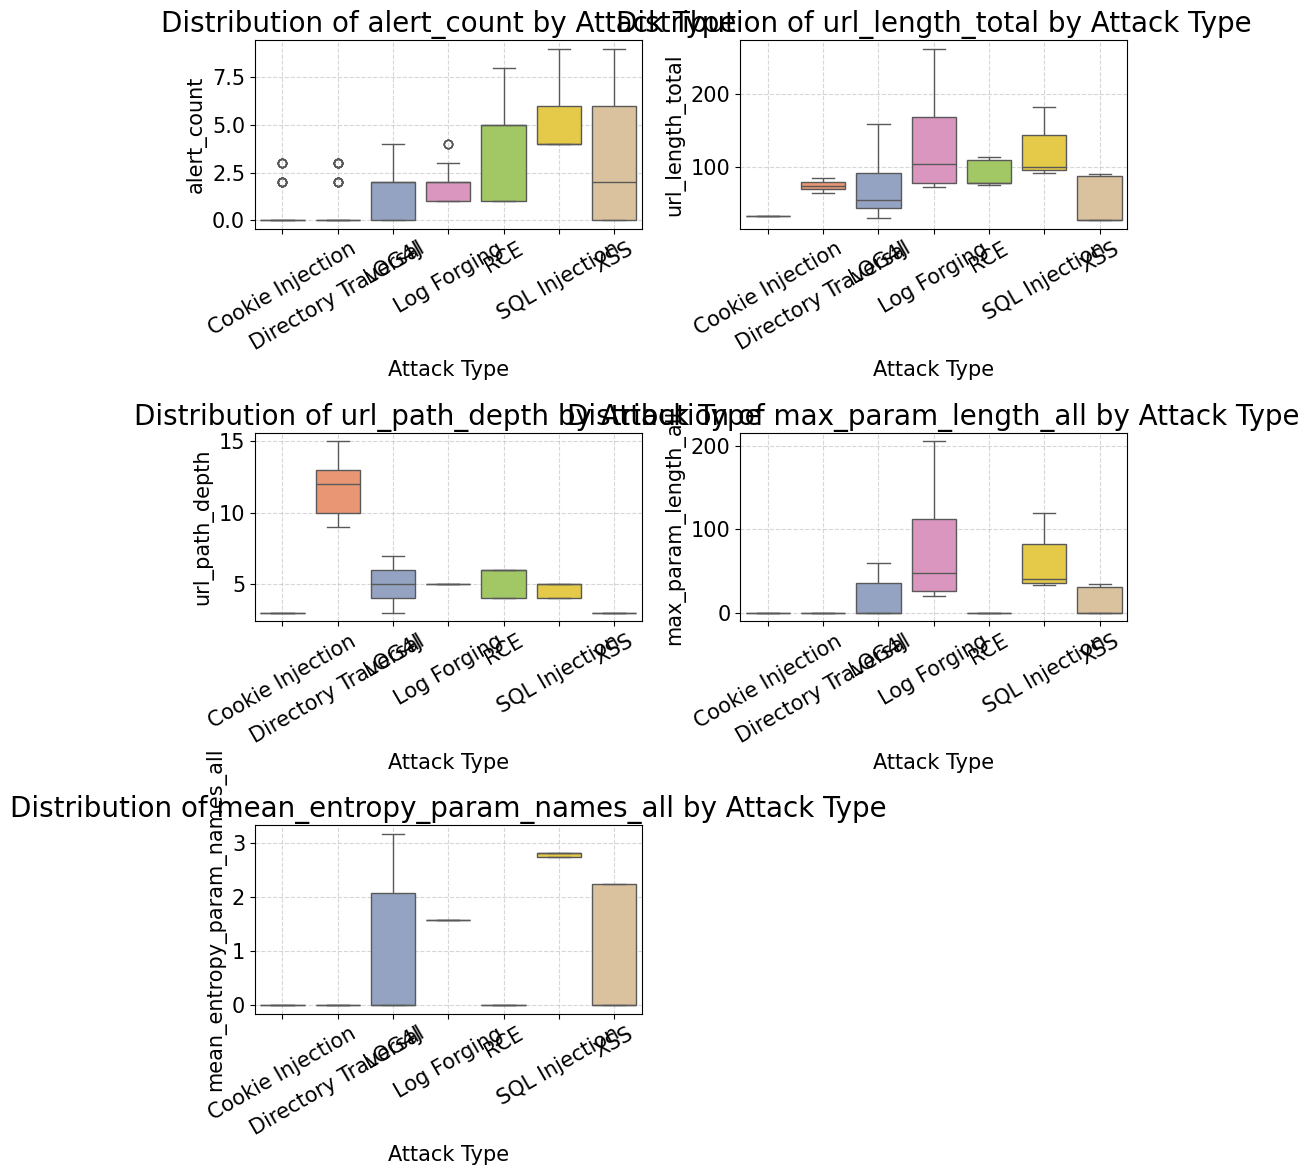

In [181]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# --- Identification of Numeric, Non-Binary Columns ---
numeric_non_binary_cols = [
    col for col in data_vizcopy2.select_dtypes(include=[np.number]).columns
    if col != 'Attack_Tag'
    and data_vizcopy2[col].notna().sum() >= 10
    and data_vizcopy2[col].nunique() > 5
]

print("Numeric, non-binary columns:", numeric_non_binary_cols)

# Pas besoin de sous-filtrage : toutes les lignes sont des attaques
n_cols = 2
n_rows = math.ceil(len(numeric_non_binary_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for i, col in enumerate(numeric_non_binary_cols):
    ax = axes.flatten()[i]
    sns.boxplot(
        data=data_vizcopy2,
        x='Attack_Tag',
        y=col,
        palette='Set2',
        ax=ax,
        order=sorted(data_vizcopy2['Attack_Tag'].unique())
    )
    ax.set_title(f"Distribution of {col} by Attack Type")
    ax.set_xlabel("Attack Type")
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=30)

for j in range(len(numeric_non_binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


Numeric, non-binary columns: ['alert_count', 'url_length_total', 'url_path_depth', 'max_param_length_all', 'mean_entropy_param_names_all']


<ipython-input-182-e846943283d9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-182-e846943283d9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-182-e846943283d9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-182-e846943283d9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-182-e846943283d9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated a

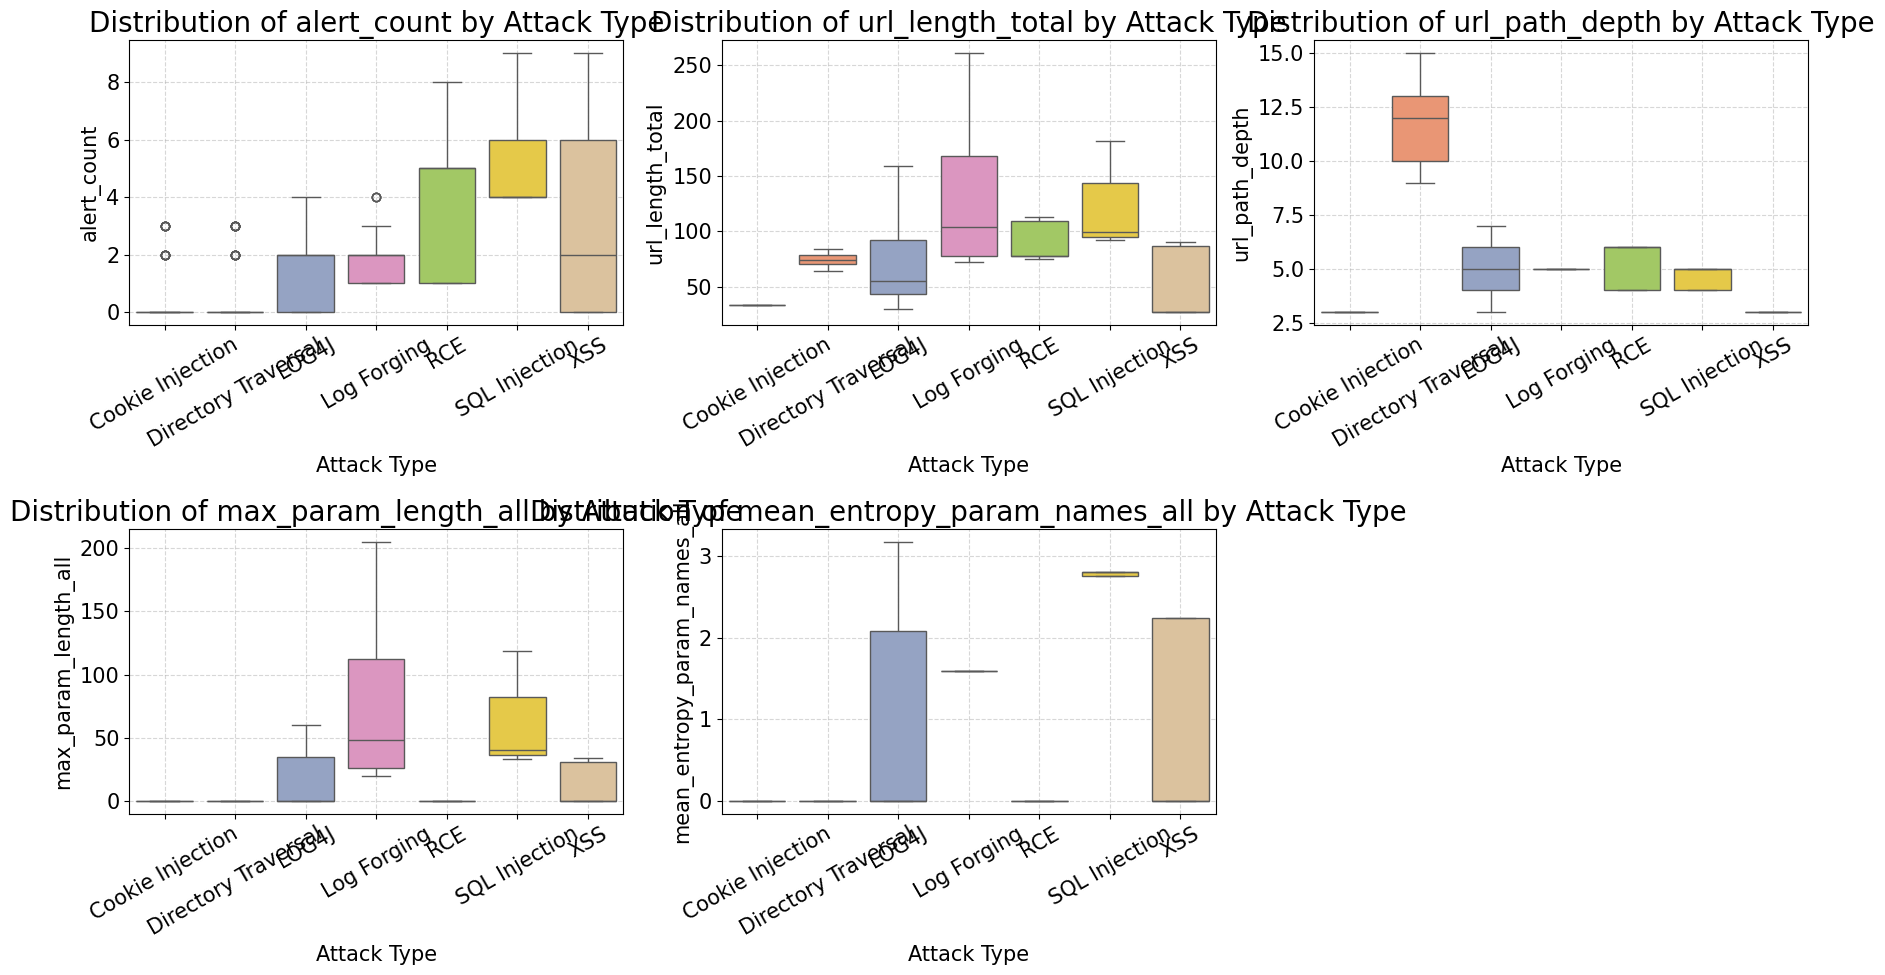

In [182]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# --- Identification of Numeric, Non-Binary Columns ---
numeric_non_binary_cols = [
    col for col in data_vizcopy2.select_dtypes(include=[np.number]).columns
    if col != 'Attack_Tag'
    and data_vizcopy2[col].notna().sum() >= 10
    and data_vizcopy2[col].nunique() > 5
]

print("Numeric, non-binary columns:", numeric_non_binary_cols)

n_cols = 3
n_rows = 2  # For up to 6 features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10))

for i, col in enumerate(numeric_non_binary_cols[:n_cols*n_rows]):
    ax = axes.flatten()[i]
    sns.boxplot(
        data=data_vizcopy2,
        x='Attack_Tag',
        y=col,
        palette='Set2',
        ax=ax,
        order=sorted(data_vizcopy2['Attack_Tag'].unique())
    )
    ax.set_title(f"Distribution of {col} by Attack Type")
    ax.set_xlabel("Attack Type")
    ax.set_ylabel(col)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=30)

# Remove unused axes if any
for j in range(len(numeric_non_binary_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


In [183]:
# --- Removal of Constant or Non-Informative Columns ---

# Identify columns that have only one unique value (constant or non-informative)
potential_constants = []
for col in data_vizcopy2.columns:
    unique_vals = data_vizcopy2[col].nunique(dropna=False)
    if unique_vals <= 1:
        potential_constants.append(col)
        print(f"{col}: unique value = {data_vizcopy2[col].unique()}")

# Drop these non-informative columns from the DataFrame
if potential_constants:
    data_vizcopy2.drop(columns=potential_constants, inplace=True)
    print(f"Dropped {len(potential_constants)} non-informative columns.")
else:
    print("No constant columns detected.")

entropy_req_body: unique value = [0.91829583]
Dropped 1 non-informative columns.


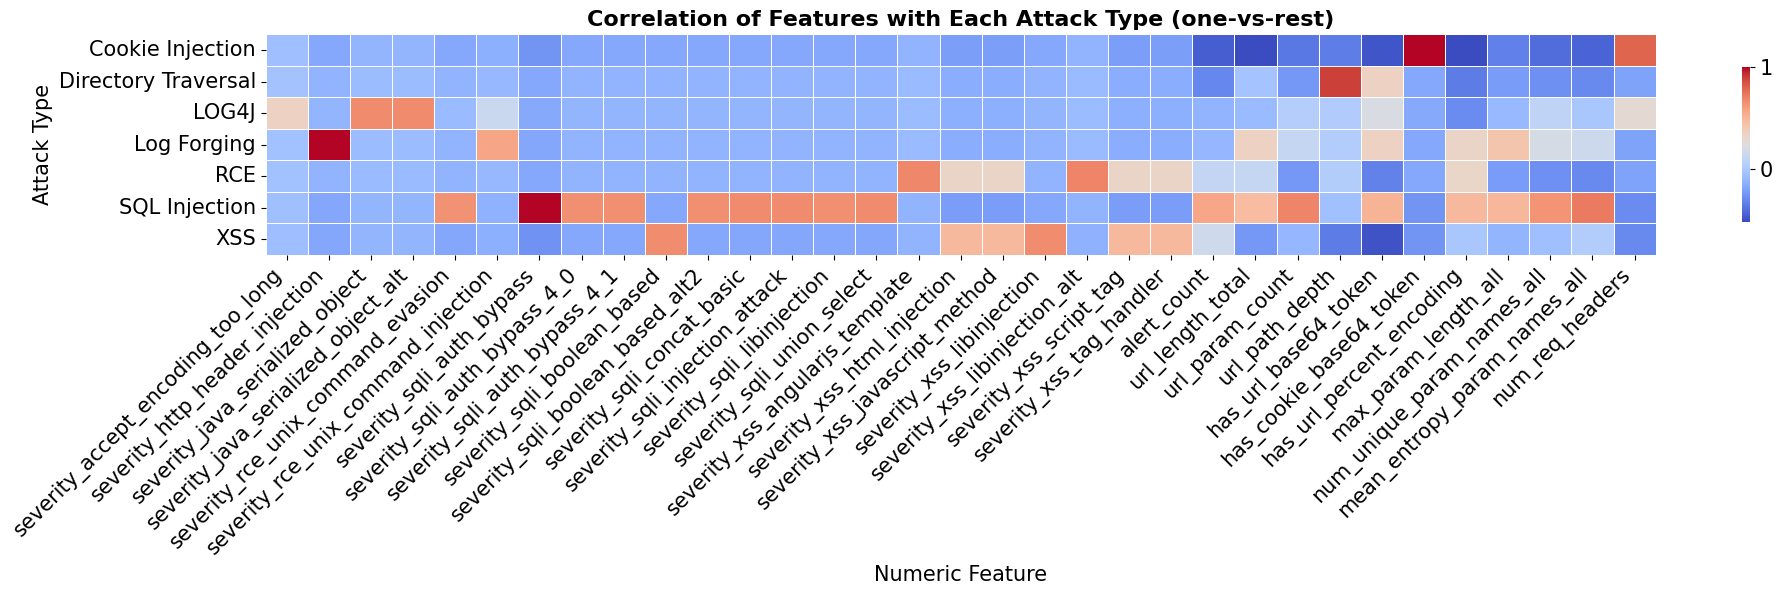

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_attacks = data_vizcopy2[data_vizcopy2['Attack_Tag'].notna()].copy()
attack_tags = sorted(df_attacks['Attack_Tag'].unique())

numeric_features = [
    col for col in df_attacks.select_dtypes(include=[np.number]).columns
    if col != 'Attack_Tag'
]

corr_matrix = pd.DataFrame(index=attack_tags, columns=numeric_features)

for attack in attack_tags:
    label_bin = (df_attacks['Attack_Tag'] == attack).astype(int)
    corrs = []
    for col in numeric_features:
        if df_attacks[col].nunique() > 1:
            corr_val = np.corrcoef(df_attacks[col], label_bin)[0, 1]
        else:
            corr_val = np.nan
        corrs.append(corr_val)
    corr_matrix.loc[attack] = corrs

corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(0.6 + 0.6 * len(numeric_features), 0.6 + 0.8 * len(attack_tags)))
sns.heatmap(
    corr_matrix,
    annot=False, fmt=".2f", cmap="coolwarm",
    linewidths=0.4, cbar_kws={"shrink": 0.7}
)
plt.title("Correlation of Features with Each Attack Type (one-vs-rest)", fontsize=16, weight='bold')
plt.ylabel("Attack Type")
plt.xlabel("Numeric Feature")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [185]:
# --- Save the Preprocessed Feature DataFrame to CSV ---

# Define the output path for the preprocessed and feature-engineered DataFrame
OUTPUT_PATH = '/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_multiclass.csv'

# Save the DataFrame to CSV format, without the index
data_vizcopy2.to_csv(OUTPUT_PATH, index=False)
print(f"Final cleaned DataFrame saved: {OUTPUT_PATH}")

# Display a summary of the DataFrame (column types, non-null counts, memory usage)
data_vizcopy2.info()

Final cleaned DataFrame saved: /content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_multiclass.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39336 entries, 0 to 39335
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Attack_Tag                           39336 non-null  object 
 1   severity_accept_encoding_too_long    39336 non-null  int64  
 2   severity_http_header_injection       39336 non-null  int64  
 3   severity_java_serialized_object      39336 non-null  int64  
 4   severity_java_serialized_object_alt  39336 non-null  int64  
 5   severity_rce_unix_command_evasion    39336 non-null  int64  
 6   severity_rce_unix_command_injection  39336 non-null  int64  
 7   severity_sqli_auth_bypass            39336 non-null  int64  
 8   severity_sqli_auth_bypass_4_0        39336 non-null  int64  
 9   severity_s